### Akshit Arora
Adopted from : https://github.com/eisenjulian/nlp_estimator_tutorial/blob/master/nlp_estimators.ipynb

In [1]:
import os
import string
import tempfile
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from collections import Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer

from tensorflow.python.keras.preprocessing import sequence
from tensorboard import summary as summary_lib

tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)

1.6.0


## Loading the data

In [2]:
DATA_PATH = "../../data/wikipedia/train.csv"
TF_PATH = "/mnt/logs"
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
comment_col = 'comment_text'
stop = stopwords.words('english') + list(string.punctuation) + list(string.printable)

In [9]:
dF = pd.read_csv(DATA_PATH)
dF.head(100)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [15]:
pd.options.display.max_colwidth = 100
print(dF[dF['id'] == '0036621e4c7e10b5']['comment_text'])

86    Would you both shut up, you don't run wikipedia, especially a stupid kid.
Name: comment_text, dtype: object


In [5]:
dF.astype(bool).sum(axis=0)

id               159571
comment_text     159571
toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
dtype: int64

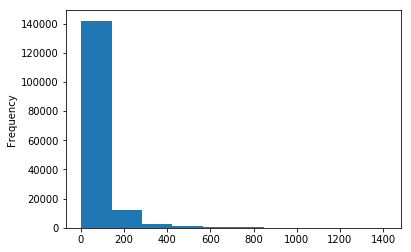

In [7]:
dF['comment_text_split'] = dF['comment_text']
(dF['comment_text_split'].apply(lambda x: len(x.split()))).plot(kind='hist') #to estimate number of words in all comments

In [8]:
output = Counter()
for i in (dF['comment_text'].apply(lambda x: x.split())):
    for j in i:
        if j.lower() not in stop:
            output[j] += 1
print(len(output))

531640


In [9]:
output.most_common(6500)[-1]

('tolerate', 105)

In [4]:
def tokenize(dataFrame, porterEnable = False):
    '''
    Tokenizes the sentence, removes stopwords and applied stemming to comments
    '''
    #dataFrame['tokenized_comment'] = dataFrame['comment_text'].apply(word_tokenize)
    dataFrame['tokenized_comment'] = dataFrame['comment_text'].apply(lambda x : filter(None,x.lower().strip().translate([None, string.punctuation]).split(" ")))
    dataFrame['tokenized_comment'] = dataFrame['tokenized_comment'].apply(lambda x: [item for item in x if item not in stop and item.isalpha()])
    #apply stemming
    if(porterEnable):
        porter = nltk.PorterStemmer()
        dataFrame['tokenized_comment'] = dataFrame['tokenized_comment'].apply(lambda x : [porter.stem(y) for y in x])
    return dataFrame

def prepareWordDict(df, limit):
    '''
    Prepares a dict of words from tokenized_comment column with their frequencies as keys. 
    Then truncates it to limit on vocabulary
    '''
    word_dict = Counter()
    for i in df['tokenized_comment']: #go per comment
        for j in i: #go per word
            word_dict[str(j)] += 1
    trunc_dict = dict(word_dict.most_common(limit-3))
    index = 3
    for key in trunc_dict: #assign unique keys to all words
        trunc_dict[key] = index
        index += 1
    return trunc_dict
    
def genSeq(df, wordDict, startId, unkId):
    '''
    generates variable length sequences based on wordDict
    '''
    sequence = []
    y = {}
    y2 = []
    for i in label_cols:
        y[i] = []
    
    for index, row in df.iterrows(): #go per comment
        temp = []
        temp.append(startId)
        for j in row['tokenized_comment']: #go per word in the list
            if(j not in wordDict):
                temp.append(unkId)
            else:
                temp.append(wordDict[j])
        if(len(temp) > 2): 
            temp_y2 = []
            for k in label_cols:
                y[k].append(row[k])
                temp_y2.append(row[k])
            y2.append(temp_y2)
            sequence.append(temp)
    return sequence, y, y2
    
def prepareSequences(dataFrame, vocabSize, split = 0.8, startId = 1, unkId = 2):
    '''
    prepares variable length sequences from the sentences to feed to pad_sequences function of keras
    args:
    dataFrame = imported from csv file
    vocabSize = Limit to number of words in vocabulary
    split = the fraction to take as training set
    startId = id that indicates start of the sentence
    unkId = id that indicates words out of vocabulary
    '''
    dataFrame = dataFrame.sample(frac=1).reset_index(drop=True) #shuffle df rows
    dataFrame = tokenize(dataFrame) #create the tokenized comment column
    wordDict = prepareWordDict(dataFrame, limit=vocabSize)
    
    #split the data
    msk = np.random.rand(len(dataFrame)) < split
    train = dataFrame[msk]
    test = dataFrame[~msk]
    
    #generate train sequences
    train_sequence, y_train, y2_train = genSeq(train, wordDict, startId, unkId)  
    
    #prepare test sequences
    test_sequence, y_test, y2_test = genSeq(test, wordDict, startId, unkId)
    
    return train_sequence, y_train, y2_train, test_sequence, y_test, y2_test, wordDict

In [5]:
vocab_size = 6500 #atleast 100 frequency
sentence_size = 400
embedding_size = 50
pad_id = 0

print("Loading data...")

x_train_variable, y_train, y2_train, x_test_variable, y_test, y2_test, word_dict = prepareSequences(dataFrame = dF, vocabSize = vocab_size)

for i in label_cols:
    print(len(y_train[i]), "train sequences")
    print(len(y_test[i]), "test sequences")
    break

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train_variable, 
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)
x_test = sequence.pad_sequences(x_test_variable, 
                                maxlen=sentence_size,
                                truncating='post',
                                padding='post', 
                                value=pad_id)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

Loading data...
122403 train sequences
30434 test sequences
Pad sequences (samples x time)
x_train shape: (122403, 400)
x_test shape: (30434, 400)


Let's inspect one of the comments.

In [6]:
pad_id = 0
start_id = 1

oov_id = 2 #same as unkId

word_inverted_index = {v: k for k, v in word_dict.items()}

# The first indexes in the map are reserved to represent things other than tokens
word_inverted_index[pad_id] = '<PAD>'
word_inverted_index[start_id] = '<START>'
word_inverted_index[oov_id] = '<OOV>'

for i in range(0, 10):
  print(i, word_inverted_index[i])
  
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

print(index_to_text(x_train_variable[1]))

0 <PAD>
1 <START>
2 <OOV>
3 article
4 would
5 page
6 like
7 one
8 please
9 talk
<START> appeal written wikipedia two pages far older present article titles also available new york site good <OOV> wiki project indian community precise pages book <OOV> writer book written registered government details registration provided news reviews one reason pages faced <OOV> bias outside india articles get deleted wikipedia minor many hits <OOV> <OOV> reflects google search engine request wiki indian community kindly come forward <OOV> help two pages fed fight case alone moved long important adds spell meaning <OOV> stay lost else community panel judge help two pages get <OOV> feel appeal <OOV>


## Building Estimators

### From arrays to tensors

In [7]:
x_len_train = np.array([min(len(x), sentence_size) for x in x_train_variable])
x_len_test = np.array([min(len(x), sentence_size) for x in x_test_variable])
model_dir = {}
for i in label_cols:
    model_dir[i] =  TF_PATH+tempfile.mkdtemp()

def parser(x, length, y):
    features = {"x": x, "len": length}
    return features, y

def train_input_fn(modelOutput = 'identity_hate'):
    dataset = tf.data.Dataset.from_tensor_slices((x_train, x_len_train, y_train[modelOutput]))
    dataset = dataset.shuffle(buffer_size=len(x_train_variable))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def eval_input_fn(modelOutput = 'identity_hate'):
    dataset = tf.data.Dataset.from_tensor_slices((x_test, x_len_test, y_test[modelOutput]))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

### Model 1: Linear Classifier

In [15]:
column = tf.feature_column.categorical_column_with_identity('x', num_buckets = vocab_size)
run_config = tf.estimator.RunConfig(save_summary_steps=None,log_step_count_steps=10,keep_checkpoint_max=1)
classifier = {}
for i in label_cols:
    classifier[i] = tf.estimator.LinearClassifier(feature_columns=[column], model_dir=os.path.join(model_dir[i], str(i)+'bow_sparse'), config=run_config)

INFO:tensorflow:Using config: {'_model_dir': '/mnt/logs/tmp/tmp1x68vd5j/toxicbow_sparse', '_tf_random_seed': None, '_save_summary_steps': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fce80946eb8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Using config: {'_model_dir': '/mnt/logs/tmp/tmpawyl75vx/severe_toxicbow_sparse', '_tf_random_seed': None, '_save_summary_steps': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribu

In [14]:
all_classifiers = {}
def train_and_evaluate(classifier, modelOutput, steps):
    # Save a reference to the classifier to run predictions later
    all_classifiers[classifier.model_dir] = classifier
    classifier.train(input_fn=lambda:train_input_fn(modelOutput), steps=steps)
    eval_results = classifier.evaluate(input_fn=lambda:eval_input_fn(modelOutput))
    predictions = np.array([p['logistic'][0] for p in classifier.predict(input_fn=lambda:eval_input_fn(modelOutput))])
        
    # Reset the graph to be able to reuse name scopes
    tf.reset_default_graph() 
    # Add a PR summary in addition to the summaries that the classifier writes
#     pr = summary_lib.pr_curve('precision_recall', predictions=predictions, labels=np.array(y_test[modelOutput]).astype(bool), num_thresholds=21)
#     with tf.Session() as sess:
#         writer = tf.summary.FileWriter(os.path.join(classifier.model_dir, 'eval'), sess.graph)
#         print("Saving to: "+str(os.path.join(classifier.model_dir, 'eval')))
#         #writer.add_summary(sess.run(pr), global_step=0)
#         writer.close()

In [11]:
for i in label_cols:
    for j in range(1):
        print("For model: "+str(i)+" repeat number: "+str(j))
        train_and_evaluate(classifier[i],i)

For model: toxic repeat number: 0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /mnt/logs/tmp/tmp1x68vd5j/toxicbow_sparse/model.ckpt.
INFO:tensorflow:loss = 69.31472, step = 1
INFO:tensorflow:global_step/sec: 91.3626
INFO:tensorflow:loss = 23.935604, step = 101 (1.096 sec)
INFO:tensorflow:global_step/sec: 101.97
INFO:tensorflow:loss = 23.143492, step = 201 (0.980 sec)
INFO:tensorflow:global_step/sec: 101.065
INFO:tensorflow:loss = 20.353077, step = 301 (0.990 sec)
INFO:tensorflow:global_step/sec: 100.741
INFO:tensorflow:loss = 14.787556, step = 401 (0.992 sec)
INFO:tensorflow:global_step/sec: 99.5945
INFO:tensorflow:loss = 31.50338, step = 501 (1.004 sec)
INFO:tensorflow:global_step/sec: 100.84
INFO:tensorflow:loss = 17.306374, step = 601 (0.992 sec)
IN

INFO:tensorflow:global_step/sec: 95.8579
INFO:tensorflow:loss = 14.395259, step = 8001 (1.045 sec)
INFO:tensorflow:global_step/sec: 98.2158
INFO:tensorflow:loss = 18.501507, step = 8101 (1.017 sec)
INFO:tensorflow:global_step/sec: 96.1763
INFO:tensorflow:loss = 7.6598077, step = 8201 (1.040 sec)
INFO:tensorflow:global_step/sec: 101.726
INFO:tensorflow:loss = 16.585398, step = 8301 (0.984 sec)
INFO:tensorflow:global_step/sec: 95.005
INFO:tensorflow:loss = 14.132166, step = 8401 (1.051 sec)
INFO:tensorflow:global_step/sec: 96.3736
INFO:tensorflow:loss = 11.343054, step = 8501 (1.039 sec)
INFO:tensorflow:global_step/sec: 66.3251
INFO:tensorflow:loss = 10.183012, step = 8601 (1.507 sec)
INFO:tensorflow:global_step/sec: 96.0206
INFO:tensorflow:loss = 18.660845, step = 8701 (1.042 sec)
INFO:tensorflow:global_step/sec: 97.7426
INFO:tensorflow:loss = 17.631287, step = 8801 (1.022 sec)
INFO:tensorflow:global_step/sec: 96.3458
INFO:tensorflow:loss = 8.404341, step = 8901 (1.038 sec)
INFO:tensorf

INFO:tensorflow:loss = 3.5167413, step = 4501 (1.038 sec)
INFO:tensorflow:global_step/sec: 95.8957
INFO:tensorflow:loss = 0.28079823, step = 4601 (1.042 sec)
INFO:tensorflow:global_step/sec: 93.76
INFO:tensorflow:loss = 1.2438576, step = 4701 (1.067 sec)
INFO:tensorflow:global_step/sec: 93.4928
INFO:tensorflow:loss = 0.46212575, step = 4801 (1.069 sec)
INFO:tensorflow:global_step/sec: 64.2258
INFO:tensorflow:loss = 2.141363, step = 4901 (1.557 sec)
INFO:tensorflow:global_step/sec: 98.1497
INFO:tensorflow:loss = 0.34270784, step = 5001 (1.019 sec)
INFO:tensorflow:global_step/sec: 97.6094
INFO:tensorflow:loss = 0.27723032, step = 5101 (1.025 sec)
INFO:tensorflow:global_step/sec: 93.5597
INFO:tensorflow:loss = 2.2191684, step = 5201 (1.070 sec)
INFO:tensorflow:global_step/sec: 95.1033
INFO:tensorflow:loss = 1.9210287, step = 5301 (1.050 sec)
INFO:tensorflow:global_step/sec: 92.8735
INFO:tensorflow:loss = 5.666052, step = 5401 (1.080 sec)
INFO:tensorflow:global_step/sec: 93.4718
INFO:tenso

INFO:tensorflow:global_step/sec: 94.0715
INFO:tensorflow:loss = 10.641884, step = 1101 (1.062 sec)
INFO:tensorflow:global_step/sec: 92.5217
INFO:tensorflow:loss = 11.055163, step = 1201 (1.082 sec)
INFO:tensorflow:global_step/sec: 68.3424
INFO:tensorflow:loss = 4.6428466, step = 1301 (1.462 sec)
INFO:tensorflow:global_step/sec: 94.2016
INFO:tensorflow:loss = 7.428696, step = 1401 (1.062 sec)
INFO:tensorflow:global_step/sec: 96.7816
INFO:tensorflow:loss = 13.761083, step = 1501 (1.034 sec)
INFO:tensorflow:global_step/sec: 98.6558
INFO:tensorflow:loss = 9.903602, step = 1601 (1.013 sec)
INFO:tensorflow:global_step/sec: 96.4923
INFO:tensorflow:loss = 12.085102, step = 1701 (1.036 sec)
INFO:tensorflow:global_step/sec: 94.1238
INFO:tensorflow:loss = 10.945882, step = 1801 (1.063 sec)
INFO:tensorflow:global_step/sec: 97.9214
INFO:tensorflow:loss = 31.937832, step = 1901 (1.020 sec)
INFO:tensorflow:global_step/sec: 98.3739
INFO:tensorflow:loss = 83.20778, step = 2001 (1.017 sec)
INFO:tensorfl

INFO:tensorflow:loss = 5.2724657, step = 9401 (1.068 sec)
INFO:tensorflow:global_step/sec: 95.9611
INFO:tensorflow:loss = 3.3750188, step = 9501 (1.043 sec)
INFO:tensorflow:global_step/sec: 97.9389
INFO:tensorflow:loss = 7.4558907, step = 9601 (1.020 sec)
INFO:tensorflow:global_step/sec: 98.5917
INFO:tensorflow:loss = 10.397361, step = 9701 (1.014 sec)
INFO:tensorflow:global_step/sec: 66.2759
INFO:tensorflow:loss = 7.731935, step = 9801 (1.509 sec)
INFO:tensorflow:global_step/sec: 99.4066
INFO:tensorflow:loss = 5.717639, step = 9901 (1.006 sec)
INFO:tensorflow:Saving checkpoints for 10000 into /mnt/logs/tmp/tmpcivx6rmt/obscenebow_sparse/model.ckpt.
INFO:tensorflow:Loss for final step: 11.396352.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-30-21:25:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/logs/tmp/tmpcivx6rmt/obscenebow_sparse/model.ckpt-10000
INFO:tensorflow:Running

INFO:tensorflow:loss = 0.38649234, step = 5901 (1.052 sec)
INFO:tensorflow:global_step/sec: 96.3753
INFO:tensorflow:loss = 0.13290432, step = 6001 (1.038 sec)
INFO:tensorflow:global_step/sec: 90.1052
INFO:tensorflow:loss = 0.15302554, step = 6101 (1.109 sec)
INFO:tensorflow:global_step/sec: 68.139
INFO:tensorflow:loss = 0.17568746, step = 6201 (1.469 sec)
INFO:tensorflow:global_step/sec: 99.0519
INFO:tensorflow:loss = 0.06847458, step = 6301 (1.009 sec)
INFO:tensorflow:global_step/sec: 95.5076
INFO:tensorflow:loss = 0.08925912, step = 6401 (1.047 sec)
INFO:tensorflow:global_step/sec: 96.1742
INFO:tensorflow:loss = 0.1949742, step = 6501 (1.041 sec)
INFO:tensorflow:global_step/sec: 97.5118
INFO:tensorflow:loss = 1.7632201, step = 6601 (1.025 sec)
INFO:tensorflow:global_step/sec: 98.178
INFO:tensorflow:loss = 2.5161874, step = 6701 (1.019 sec)
INFO:tensorflow:global_step/sec: 96.4551
INFO:tensorflow:loss = 3.9444818, step = 6801 (1.037 sec)
INFO:tensorflow:global_step/sec: 95.5086
INFO:t

INFO:tensorflow:global_step/sec: 67.0627
INFO:tensorflow:loss = 2.5320024, step = 2501 (1.492 sec)
INFO:tensorflow:global_step/sec: 101.8
INFO:tensorflow:loss = 9.145264, step = 2601 (0.981 sec)
INFO:tensorflow:global_step/sec: 94.5341
INFO:tensorflow:loss = 8.043345, step = 2701 (1.057 sec)
INFO:tensorflow:global_step/sec: 93.9839
INFO:tensorflow:loss = 13.067324, step = 2801 (1.065 sec)
INFO:tensorflow:global_step/sec: 96.8737
INFO:tensorflow:loss = 10.077432, step = 2901 (1.031 sec)
INFO:tensorflow:global_step/sec: 100.338
INFO:tensorflow:loss = 9.189615, step = 3001 (0.997 sec)
INFO:tensorflow:global_step/sec: 95.4916
INFO:tensorflow:loss = 4.796143, step = 3101 (1.047 sec)
INFO:tensorflow:global_step/sec: 95.5151
INFO:tensorflow:loss = 10.015681, step = 3201 (1.048 sec)
INFO:tensorflow:global_step/sec: 96.2676
INFO:tensorflow:loss = 6.9717965, step = 3301 (1.038 sec)
INFO:tensorflow:global_step/sec: 94.6919
INFO:tensorflow:loss = 11.812191, step = 3401 (1.056 sec)
INFO:tensorflow:

INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.9629033, accuracy_baseline = 0.95248735, auc = 0.9186641, auc_precision_recall = 0.5686723, average_loss = 0.17688742, global_step = 10000, label/mean = 0.04751265, loss = 17.650465, precision = 0.7602627, prediction/mean = 0.036592524, recall = 0.32019365
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/logs/tmp/tmpgewi8y5f/insultbow_sparse/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
For model: identity_hate repeat number: 0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /mnt/logs/tmp/tmpve429af4/identity_hatebow_sparse/model.ckp

INFO:tensorflow:loss = 9.375281, step = 7301 (1.074 sec)
INFO:tensorflow:global_step/sec: 67.0899
INFO:tensorflow:loss = 2.7830915, step = 7401 (1.491 sec)
INFO:tensorflow:global_step/sec: 98.3679
INFO:tensorflow:loss = 0.21187487, step = 7501 (1.016 sec)
INFO:tensorflow:global_step/sec: 104.836
INFO:tensorflow:loss = 1.2138897, step = 7601 (0.954 sec)
INFO:tensorflow:global_step/sec: 105.067
INFO:tensorflow:loss = 7.368141, step = 7701 (0.952 sec)
INFO:tensorflow:global_step/sec: 104.939
INFO:tensorflow:loss = 1.5476187, step = 7801 (0.953 sec)
INFO:tensorflow:global_step/sec: 104.448
INFO:tensorflow:loss = 0.46146673, step = 7901 (0.958 sec)
INFO:tensorflow:global_step/sec: 98.5015
INFO:tensorflow:loss = 3.4788575, step = 8001 (1.015 sec)
INFO:tensorflow:global_step/sec: 93.5891
INFO:tensorflow:loss = 7.1135163, step = 8101 (1.069 sec)
INFO:tensorflow:global_step/sec: 98.8967
INFO:tensorflow:loss = 0.7918054, step = 8201 (1.012 sec)
INFO:tensorflow:global_step/sec: 103.577
INFO:tenso

toxic


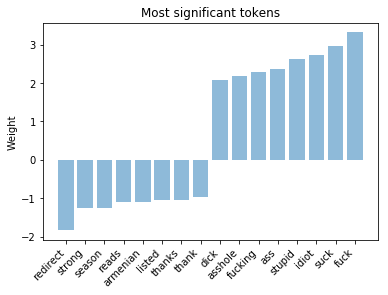

severe_toxic


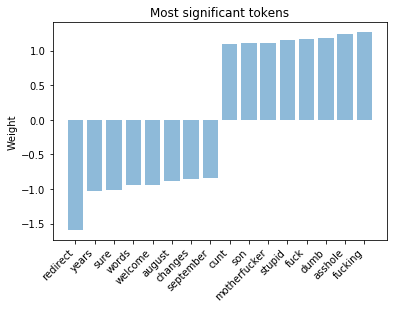

obscene


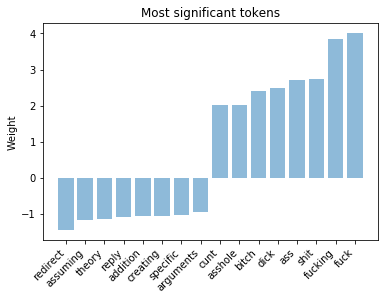

threat


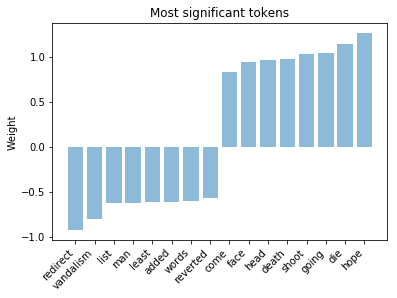

insult


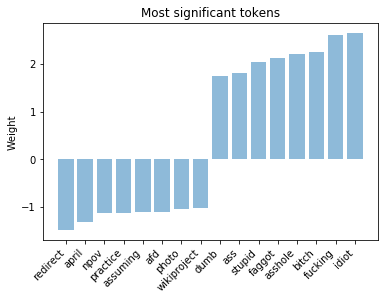

identity_hate


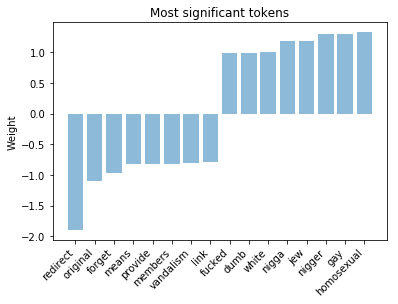

In [14]:
for idx, i in enumerate(label_cols):
    print(str(i))
    weights = classifier[i].get_variable_value('linear/linear_model/x/weights').flatten()
    sorted_indexes = np.argsort(weights)
    extremes = np.concatenate((sorted_indexes[-8:], sorted_indexes[:8]))
    extreme_weights = sorted([(weights[i], word_inverted_index[i]) for i in extremes])
    y_pos = np.arange(len(extreme_weights))
    plt.bar(y_pos, [pair[0] for pair in extreme_weights], align='center', alpha=0.5)
    plt.xticks(y_pos, [pair[1] for pair in extreme_weights], rotation=45, ha='right')
    plt.ylabel('Weight')
    plt.title('Most significant tokens') 
    plt.show()

### Model 2: DNN Classifier with Embeddings

In [23]:
word_embedding_column = tf.feature_column.embedding_column(column, dimension=embedding_size)
run_config = tf.estimator.RunConfig(save_summary_steps=None,log_step_count_steps=100,keep_checkpoint_max=1)
classifier = {}
for i in label_cols:
    for j in range(1):
        print("For model: "+str(i)+" repeat number: "+str(j))
        classifier[i] = tf.estimator.DNNClassifier(hidden_units=[100], feature_columns=[word_embedding_column], model_dir=os.path.join(model_dir[i], str(i)+'bow_embeddings'), config=run_config)
        train_and_evaluate(classifier[i],i)

For model: toxic repeat number: 0
INFO:tensorflow:Using config: {'_model_dir': '../logs/tmp/tmpzwv83gw5/toxicbow_embeddings', '_tf_random_seed': None, '_save_summary_steps': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0e3d5bc9e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ../logs/tmp/tmpzwv83gw5/toxicbow_

INFO:tensorflow:loss = 16.274057, step = 7301 (0.860 sec)
INFO:tensorflow:global_step/sec: 94.6328
INFO:tensorflow:loss = 10.821818, step = 7401 (1.056 sec)
INFO:tensorflow:global_step/sec: 122.861
INFO:tensorflow:loss = 18.146715, step = 7501 (0.814 sec)
INFO:tensorflow:global_step/sec: 121.026
INFO:tensorflow:loss = 11.89967, step = 7601 (0.826 sec)
INFO:tensorflow:global_step/sec: 120.877
INFO:tensorflow:loss = 8.591156, step = 7701 (0.827 sec)
INFO:tensorflow:global_step/sec: 117.598
INFO:tensorflow:loss = 8.161214, step = 7801 (0.850 sec)
INFO:tensorflow:global_step/sec: 113.063
INFO:tensorflow:loss = 16.871098, step = 7901 (0.884 sec)
INFO:tensorflow:global_step/sec: 117.349
INFO:tensorflow:loss = 21.060215, step = 8001 (0.852 sec)
INFO:tensorflow:global_step/sec: 116.759
INFO:tensorflow:loss = 12.648585, step = 8101 (0.856 sec)
INFO:tensorflow:global_step/sec: 120.726
INFO:tensorflow:loss = 13.1847725, step = 8201 (0.828 sec)
INFO:tensorflow:global_step/sec: 120.12
INFO:tensorfl

INFO:tensorflow:global_step/sec: 120.109
INFO:tensorflow:loss = 10.048675, step = 3201 (0.833 sec)
INFO:tensorflow:global_step/sec: 121.435
INFO:tensorflow:loss = 1.3163071, step = 3301 (0.823 sec)
INFO:tensorflow:global_step/sec: 120.93
INFO:tensorflow:loss = 0.7984003, step = 3401 (0.827 sec)
INFO:tensorflow:global_step/sec: 121.431
INFO:tensorflow:loss = 0.7812297, step = 3501 (0.823 sec)
INFO:tensorflow:global_step/sec: 117.105
INFO:tensorflow:loss = 1.2424084, step = 3601 (0.854 sec)
INFO:tensorflow:global_step/sec: 93.9673
INFO:tensorflow:loss = 11.139805, step = 3701 (1.064 sec)
INFO:tensorflow:global_step/sec: 119.993
INFO:tensorflow:loss = 9.694518, step = 3801 (0.833 sec)
INFO:tensorflow:global_step/sec: 118.672
INFO:tensorflow:loss = 9.754657, step = 3901 (0.843 sec)
INFO:tensorflow:global_step/sec: 120.543
INFO:tensorflow:loss = 0.6021534, step = 4001 (0.830 sec)
INFO:tensorflow:global_step/sec: 119.957
INFO:tensorflow:loss = 6.100364, step = 4101 (0.834 sec)
INFO:tensorflo

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ../logs/tmp/tmpypwvqhjb/obscenebow_embeddings/model.ckpt.
INFO:tensorflow:loss = 69.29767, step = 1
INFO:tensorflow:global_step/sec: 110.107
INFO:tensorflow:loss = 17.230179, step = 101 (0.909 sec)
INFO:tensorflow:global_step/sec: 121.321
INFO:tensorflow:loss = 26.032978, step = 201 (0.824 sec)
INFO:tensorflow:global_step/sec: 121.209
INFO:tensorflow:loss = 29.831936, step = 301 (0.825 sec)
INFO:tensorflow:global_step/sec: 120.291
INFO:tensorflow:loss = 16.933798, step = 401 (0.831 sec)
INFO:tensorflow:global_step/sec: 121.581
INFO:tensorflow:loss = 13.7747, step = 501 (0.823 sec)
INFO:tensorflow:global_step/sec: 120.15
INFO:tensorflow:loss = 22.77251, step = 601 (0.832 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:loss = 11.781223, step = 8001 (0.823 sec)
INFO:tensorflow:global_step/sec: 120.69
INFO:tensorflow:loss = 10.677166, step = 8101 (0.829 sec)
INFO:tensorflow:global_step/sec: 119.948
INFO:tensorflow:loss = 9.681931, step = 8201 (0.834 sec)
INFO:tensorflow:global_step/sec: 119.928
INFO:tensorflow:loss = 6.2912903, step = 8301 (0.834 sec)
INFO:tensorflow:global_step/sec: 119.779
INFO:tensorflow:loss = 7.815332, step = 8401 (0.835 sec)
INFO:tensorflow:global_step/sec: 118.001
INFO:tensorflow:loss = 9.356226, step = 8501 (0.847 sec)
INFO:tensorflow:global_step/sec: 94.9007
INFO:tensorflow:loss = 10.395608, step = 8601 (1.054 sec)
INFO:tensorflow:global_step/sec: 120.938
INFO:tensorflow:loss = 7.3560166, step = 8701 (0.827 sec)
INFO:tensorflow:global_step/sec: 120.056
INFO:tensorflow:loss = 10.032539, step = 8801 (0.833 sec)
INFO:tensorflow:global_step/sec: 120.915
INFO:tensorflow:loss = 13.434375, step = 8901 (0.827 sec)
INFO:tensorflow:global_step/sec: 119.669
INFO:tensorflo

INFO:tensorflow:global_step/sec: 121.575
INFO:tensorflow:loss = 0.19054784, step = 3901 (0.823 sec)
INFO:tensorflow:global_step/sec: 122.061
INFO:tensorflow:loss = 0.34609267, step = 4001 (0.819 sec)
INFO:tensorflow:global_step/sec: 121.444
INFO:tensorflow:loss = 0.25397074, step = 4101 (0.823 sec)
INFO:tensorflow:global_step/sec: 121.196
INFO:tensorflow:loss = 0.20246224, step = 4201 (0.825 sec)
INFO:tensorflow:global_step/sec: 121.994
INFO:tensorflow:loss = 6.109612, step = 4301 (0.820 sec)
INFO:tensorflow:global_step/sec: 121.689
INFO:tensorflow:loss = 0.36786288, step = 4401 (0.822 sec)
INFO:tensorflow:global_step/sec: 121.162
INFO:tensorflow:loss = 0.49492747, step = 4501 (0.825 sec)
INFO:tensorflow:global_step/sec: 121.157
INFO:tensorflow:loss = 0.33015814, step = 4601 (0.825 sec)
INFO:tensorflow:global_step/sec: 122.139
INFO:tensorflow:loss = 0.38778478, step = 4701 (0.819 sec)
INFO:tensorflow:global_step/sec: 119.493
INFO:tensorflow:loss = 0.25923944, step = 4801 (0.837 sec)
IN

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ../logs/tmp/tmpbnc7uk13/insultbow_embeddings/model.ckpt.
INFO:tensorflow:loss = 65.42856, step = 1
INFO:tensorflow:global_step/sec: 109.736
INFO:tensorflow:loss = 17.08899, step = 101 (0.912 sec)
INFO:tensorflow:global_step/sec: 121.2
INFO:tensorflow:loss = 22.986656, step = 201 (0.825 sec)
INFO:tensorflow:global_step/sec: 121.888
INFO:tensorflow:loss = 20.23271, step = 301 (0.821 sec)
INFO:tensorflow:global_step/sec: 121.306
INFO:tensorflow:loss = 23.133677, step = 401 (0.824 sec)
INFO:tensorflow:global_step/sec: 121.524
INFO:tensorflow:loss = 11.020594, step = 501 (0.823 sec)
INFO:tensorflow:global_step/sec: 122.834
INFO:tensorflow:loss = 19.849882, step = 601 (0.814 sec)
INFO:tensorflow:global_step/sec: 122.597
INFO:tensorflow:loss = 19.8

INFO:tensorflow:global_step/sec: 121.649
INFO:tensorflow:loss = 3.845956, step = 8101 (0.822 sec)
INFO:tensorflow:global_step/sec: 120.413
INFO:tensorflow:loss = 7.4218583, step = 8201 (0.831 sec)
INFO:tensorflow:global_step/sec: 117.399
INFO:tensorflow:loss = 7.268351, step = 8301 (0.852 sec)
INFO:tensorflow:global_step/sec: 115.436
INFO:tensorflow:loss = 13.821672, step = 8401 (0.866 sec)
INFO:tensorflow:global_step/sec: 110.725
INFO:tensorflow:loss = 9.435868, step = 8501 (0.903 sec)
INFO:tensorflow:global_step/sec: 95.6709
INFO:tensorflow:loss = 16.723787, step = 8601 (1.045 sec)
INFO:tensorflow:global_step/sec: 122.672
INFO:tensorflow:loss = 9.656849, step = 8701 (0.815 sec)
INFO:tensorflow:global_step/sec: 122.325
INFO:tensorflow:loss = 17.110764, step = 8801 (0.817 sec)
INFO:tensorflow:global_step/sec: 120.08
INFO:tensorflow:loss = 9.596524, step = 8901 (0.833 sec)
INFO:tensorflow:global_step/sec: 122.826
INFO:tensorflow:loss = 15.022539, step = 9001 (0.814 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 117.342
INFO:tensorflow:loss = 1.032075, step = 4001 (0.852 sec)
INFO:tensorflow:global_step/sec: 115.167
INFO:tensorflow:loss = 5.599015, step = 4101 (0.868 sec)
INFO:tensorflow:global_step/sec: 113.614
INFO:tensorflow:loss = 5.5679064, step = 4201 (0.880 sec)
INFO:tensorflow:global_step/sec: 118.894
INFO:tensorflow:loss = 5.6111608, step = 4301 (0.841 sec)
INFO:tensorflow:global_step/sec: 121.018
INFO:tensorflow:loss = 9.904433, step = 4401 (0.826 sec)
INFO:tensorflow:global_step/sec: 121.661
INFO:tensorflow:loss = 5.6657944, step = 4501 (0.822 sec)
INFO:tensorflow:global_step/sec: 119.626
INFO:tensorflow:loss = 11.032007, step = 4601 (0.836 sec)
INFO:tensorflow:global_step/sec: 120.205
INFO:tensorflow:loss = 0.89882344, step = 4701 (0.832 sec)
INFO:tensorflow:global_step/sec: 118.518
INFO:tensorflow:loss = 10.220994, step = 4801 (0.844 sec)
INFO:tensorflow:global_step/sec: 92.4015
INFO:tensorflow:loss = 0.6833964, step = 4901 (1.082 sec)
INFO:tensorf

### Model 3: Convolutional Neural Network

In [24]:
head = tf.contrib.estimator.binary_classification_head()

def cnn_model_fn(features, labels, mode, params):    
    input_layer = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size, initializer=params['embedding_initializer'])
    
    training = mode == tf.estimator.ModeKeys.TRAIN
    dropout_emb = tf.layers.dropout(inputs=input_layer, 
                                    rate=0.2, 
                                    training=training)

    conv = tf.layers.conv1d(
        inputs=dropout_emb,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # Global Max Pooling
    pool = tf.reduce_max(input_tensor=conv, axis=1)
    
    hidden = tf.layers.dense(inputs=pool, units=250, activation=tf.nn.relu)
    
    dropout_hidden = tf.layers.dropout(inputs=hidden, 
                                       rate=0.2, 
                                       training=training)
    
    logits = tf.layers.dense(inputs=dropout_hidden, units=1)
    
    # This will be None when predicting
    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
        

    optimizer = tf.train.AdamOptimizer()
    
    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits, 
        train_op_fn=_train_op_fn)

# params = {}
# cnn_classifier = {}
# for i in label_cols:
#     for j in range(1):
#         print("For model: "+str(i)+" repeat number: "+str(j))
#         params[i] = {'embedding_initializer': tf.random_uniform_initializer(-1.0, 1.0)}
#         cnn_classifier[i] = tf.estimator.Estimator(model_fn=cnn_model_fn,model_dir=os.path.join(model_dir[i], str(i)+'cnn'),params=params[i], config=run_config)
#         train_and_evaluate(cnn_classifier[i],i)

### Model 4: LSTM

In [18]:
head = tf.contrib.estimator.binary_classification_head()

def lstm_model_fn(features, labels, mode):    
    # [batch_size x sentence_size x embedding_size]
    inputs = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size,
        initializer=tf.random_uniform_initializer(-1.0, 1.0))

    # create an LSTM cell of size 100
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(100)
    
    # create the complete LSTM
    _, final_states = tf.nn.dynamic_rnn(
        lstm_cell, inputs, sequence_length=features['len'], dtype=tf.float32)

    # get the final hidden states of dimensionality [batch_size x sentence_size]
    outputs = final_states.h

    logits = tf.layers.dense(inputs=outputs, units=1)

    # This will be None when predicting
    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])

    optimizer = tf.train.AdamOptimizer()

    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits,
        train_op_fn=_train_op_fn)

params = {}
lstm_classifier = {}
for i in label_cols:
    for j in range(1):
        print("For model: "+str(i)+" repeat number: "+str(j))
        lstm_classifier[i] = tf.estimator.Estimator(model_fn=lstm_model_fn,
                                             model_dir=os.path.join(model_dir[i], str(i)+'lstm'), config=run_config)
        train_and_evaluate(lstm_classifier[i], i, steps=1000)

For model: toxic repeat number: 0
INFO:tensorflow:Using config: {'_model_dir': '/mnt/logs/tmp/tmp1x68vd5j/toxiclstm', '_tf_random_seed': None, '_save_summary_steps': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fce91c89748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/logs/tmp/tmp1x68vd5j/toxiclstm/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_

KeyboardInterrupt: 

### Pretrained vectors


In [20]:
# if not os.path.exists('~/ubuntu/glove.6B.zip'):
#     ! wget https://nlp.stanford.edu/data/glove.6B.zip
# if not os.path.exists('~/ubuntu/glove.6B.50d.txt'):
#     ! unzip glove.6B.zip

^C
Archive:  glove.6B.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of glove.6B.zip or
        glove.6B.zip.zip, and cannot find glove.6B.zip.ZIP, period.


In [22]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors

    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, embedding_size))
    num_loaded = 0
    for w, i in word_dict.items():
        v = embeddings.get(w)
        if v is not None and i < vocab_size:
            embedding_matrix[i] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for '
          f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_glove_embeddings('/home/ubuntu/glove.6B.50d.txt')

Successfully loaded pretrained embeddings for 6395/6500 words.


In [27]:
def my_initializer(shape=None, dtype=tf.float32, partition_info=None):
    assert dtype is tf.float32
    return embedding_matrix

params = {}
cnn_classifier = {}
for i in label_cols:
    for j in range(1):
        print("For model: "+str(i)+" repeat number: "+str(j))
        params[i] = {'embedding_initializer': tf.random_uniform_initializer(-1.0, 1.0)}
        cnn_classifier[i] = tf.estimator.Estimator(model_fn=cnn_model_fn,model_dir=os.path.join(model_dir[i], str(i)+'cnn_pretrained'),params=params[i], config=run_config)
        train_and_evaluate(cnn_classifier[i],i, steps=10000)

For model: toxic repeat number: 0
INFO:tensorflow:Using config: {'_model_dir': '/mnt/logs/tmp/tmp1x68vd5j/toxiccnn_pretrained', '_tf_random_seed': None, '_save_summary_steps': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fce949d6cc0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/logs/tmp/tmp1x68vd5j/toxiccnn_pretrained/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Don

INFO:tensorflow:loss = 0.19071072, step = 921 (0.563 sec)
INFO:tensorflow:global_step/sec: 18.2583
INFO:tensorflow:loss = 0.109846614, step = 931 (0.548 sec)
INFO:tensorflow:global_step/sec: 16.3776
INFO:tensorflow:loss = 0.21027403, step = 941 (0.610 sec)
INFO:tensorflow:global_step/sec: 20.9133
INFO:tensorflow:loss = 0.13042276, step = 951 (0.478 sec)
INFO:tensorflow:global_step/sec: 18.3127
INFO:tensorflow:loss = 0.21613306, step = 961 (0.546 sec)
INFO:tensorflow:global_step/sec: 20.3699
INFO:tensorflow:loss = 0.17187414, step = 971 (0.492 sec)
INFO:tensorflow:global_step/sec: 20.0673
INFO:tensorflow:loss = 0.105879195, step = 981 (0.498 sec)
INFO:tensorflow:global_step/sec: 20.9781
INFO:tensorflow:loss = 0.19091338, step = 991 (0.477 sec)
INFO:tensorflow:global_step/sec: 20.8407
INFO:tensorflow:loss = 0.23089045, step = 1001 (0.480 sec)
INFO:tensorflow:global_step/sec: 21.7431
INFO:tensorflow:loss = 0.34829426, step = 1011 (0.460 sec)
INFO:tensorflow:global_step/sec: 21.6412
INFO:t

INFO:tensorflow:loss = 0.010131877, step = 491 (0.455 sec)
INFO:tensorflow:global_step/sec: 22.168
INFO:tensorflow:loss = 0.09029082, step = 501 (0.451 sec)
INFO:tensorflow:global_step/sec: 21.8042
INFO:tensorflow:loss = 0.046701, step = 511 (0.458 sec)
INFO:tensorflow:global_step/sec: 21.9111
INFO:tensorflow:loss = 0.047434565, step = 521 (0.456 sec)
INFO:tensorflow:global_step/sec: 21.231
INFO:tensorflow:loss = 0.033845197, step = 531 (0.471 sec)
INFO:tensorflow:global_step/sec: 20.5404
INFO:tensorflow:loss = 0.047068227, step = 541 (0.488 sec)
INFO:tensorflow:global_step/sec: 22.1936
INFO:tensorflow:loss = 0.00474257, step = 551 (0.450 sec)
INFO:tensorflow:global_step/sec: 21.2514
INFO:tensorflow:loss = 0.024239793, step = 561 (0.471 sec)
INFO:tensorflow:global_step/sec: 20.5362
INFO:tensorflow:loss = 0.02945225, step = 571 (0.487 sec)
INFO:tensorflow:global_step/sec: 21.6763
INFO:tensorflow:loss = 0.02528758, step = 581 (0.461 sec)
INFO:tensorflow:global_step/sec: 21.015
INFO:tenso

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/logs/tmp/tmpawyl75vx/severe_toxiccnn_pretrained/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
For model: obscene repeat number: 0
INFO:tensorflow:Using config: {'_model_dir': '/mnt/logs/tmp/tmpcivx6rmt/obscenecnn_pretrained', '_tf_random_seed': None, '_save_summary_steps': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fce91b285f8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:te

INFO:tensorflow:global_step/sec: 22.1977
INFO:tensorflow:loss = 0.12976007, step = 891 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.2842
INFO:tensorflow:loss = 0.053677607, step = 901 (0.449 sec)
INFO:tensorflow:global_step/sec: 21.5867
INFO:tensorflow:loss = 0.14133354, step = 911 (0.463 sec)
INFO:tensorflow:global_step/sec: 22.4126
INFO:tensorflow:loss = 0.16860235, step = 921 (0.446 sec)
INFO:tensorflow:global_step/sec: 21.9123
INFO:tensorflow:loss = 0.117164515, step = 931 (0.456 sec)
INFO:tensorflow:global_step/sec: 22.0989
INFO:tensorflow:loss = 0.03410996, step = 941 (0.453 sec)
INFO:tensorflow:global_step/sec: 22.5516
INFO:tensorflow:loss = 0.14393224, step = 951 (0.444 sec)
INFO:tensorflow:global_step/sec: 22.4941
INFO:tensorflow:loss = 0.19169945, step = 961 (0.444 sec)
INFO:tensorflow:global_step/sec: 22.2028
INFO:tensorflow:loss = 0.0840994, step = 971 (0.451 sec)
INFO:tensorflow:global_step/sec: 21.1381
INFO:tensorflow:loss = 0.090579, step = 981 (0.473 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 23.0677
INFO:tensorflow:loss = 0.0036428315, step = 461 (0.433 sec)
INFO:tensorflow:global_step/sec: 23.1575
INFO:tensorflow:loss = 0.00803599, step = 471 (0.432 sec)
INFO:tensorflow:global_step/sec: 23.1611
INFO:tensorflow:loss = 0.00432906, step = 481 (0.432 sec)
INFO:tensorflow:global_step/sec: 23.5401
INFO:tensorflow:loss = 0.0023203553, step = 491 (0.425 sec)
INFO:tensorflow:global_step/sec: 23.2934
INFO:tensorflow:loss = 0.0019623593, step = 501 (0.429 sec)
INFO:tensorflow:global_step/sec: 22.8245
INFO:tensorflow:loss = 0.0019661398, step = 511 (0.439 sec)
INFO:tensorflow:global_step/sec: 22.7573
INFO:tensorflow:loss = 0.0031388, step = 521 (0.439 sec)
INFO:tensorflow:global_step/sec: 22.7593
INFO:tensorflow:loss = 0.0019185815, step = 531 (0.439 sec)
INFO:tensorflow:global_step/sec: 22.5149
INFO:tensorflow:loss = 0.054447226, step = 541 (0.447 sec)
INFO:tensorflow:global_step/sec: 20.7799
INFO:tensorflow:loss = 0.00742431, step = 551 (0.478 sec)


INFO:tensorflow:Finished evaluation at 2018-04-30-22:43:13
INFO:tensorflow:Saving dict for global step 1200: accuracy = 0.9969442, accuracy_baseline = 0.9969442, auc = 0.8532762, auc_precision_recall = 0.038562283, average_loss = 0.019322278, global_step = 1200, label/mean = 0.0030557928, loss = 0.01929592, precision = 0.0, prediction/mean = 0.007637471, recall = 0.0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/logs/tmp/tmpbaq3jyt6/threatcnn_pretrained/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
For model: insult repeat number: 0
INFO:tensorflow:Using config: {'_model_dir': '/mnt/logs/tmp/tmpgewi8y5f/insultcnn_pretrained', '_tf_random_seed': None, '_save_summary_steps': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours'

INFO:tensorflow:loss = 0.085785314, step = 851 (0.504 sec)
INFO:tensorflow:global_step/sec: 20.9596
INFO:tensorflow:loss = 0.13716747, step = 861 (0.477 sec)
INFO:tensorflow:global_step/sec: 20.4267
INFO:tensorflow:loss = 0.15800638, step = 871 (0.490 sec)
INFO:tensorflow:global_step/sec: 21.7559
INFO:tensorflow:loss = 0.05369662, step = 881 (0.460 sec)
INFO:tensorflow:global_step/sec: 21.3933
INFO:tensorflow:loss = 0.22440578, step = 891 (0.468 sec)
INFO:tensorflow:global_step/sec: 21.9248
INFO:tensorflow:loss = 0.09560687, step = 901 (0.456 sec)
INFO:tensorflow:global_step/sec: 21.1837
INFO:tensorflow:loss = 0.066159345, step = 911 (0.472 sec)
INFO:tensorflow:global_step/sec: 20.5131
INFO:tensorflow:loss = 0.082214504, step = 921 (0.487 sec)
INFO:tensorflow:global_step/sec: 20.6861
INFO:tensorflow:loss = 0.08637782, step = 931 (0.484 sec)
INFO:tensorflow:global_step/sec: 21.2156
INFO:tensorflow:loss = 0.14823468, step = 941 (0.472 sec)
INFO:tensorflow:global_step/sec: 21.0342
INFO:te

INFO:tensorflow:loss = 0.010903393, step = 421 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.0531
INFO:tensorflow:loss = 0.006806916, step = 431 (0.454 sec)
INFO:tensorflow:global_step/sec: 22.226
INFO:tensorflow:loss = 0.0072880965, step = 441 (0.449 sec)
INFO:tensorflow:global_step/sec: 22.8175
INFO:tensorflow:loss = 0.007906898, step = 451 (0.438 sec)
INFO:tensorflow:global_step/sec: 22.042
INFO:tensorflow:loss = 0.00968962, step = 461 (0.454 sec)
INFO:tensorflow:global_step/sec: 22.0257
INFO:tensorflow:loss = 0.0648805, step = 471 (0.455 sec)
INFO:tensorflow:global_step/sec: 22.7432
INFO:tensorflow:loss = 0.0040772296, step = 481 (0.439 sec)
INFO:tensorflow:global_step/sec: 22.4403
INFO:tensorflow:loss = 0.0059748595, step = 491 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.5224
INFO:tensorflow:loss = 0.0140464185, step = 501 (0.444 sec)
INFO:tensorflow:global_step/sec: 22.8
INFO:tensorflow:loss = 0.12647215, step = 511 (0.438 sec)
INFO:tensorflow:global_step/sec: 22.3731
INFO:

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-30-22:47:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/logs/tmp/tmpve429af4/identity_hatecnn_pretrained/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-30-22:47:48
INFO:tensorflow:Saving dict for global step 1200: accuracy = 0.99106264, accuracy_baseline = 0.99129266, auc = 0.8868806, auc_precision_recall = 0.21633355, average_loss = 0.036966383, global_step = 1200, label/mean = 0.008707367, loss = 0.036901873, precision = 0.44615385, prediction/mean = 0.013900398, recall = 0.109433964
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/logs/tmp/tmpve429af4/identity_hatecnn_pretrained/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done ru

In [28]:
def my_initializer(shape=None, dtype=tf.float32, partition_info=None):
    assert dtype is tf.float32
    return embedding_matrix

params = {}
cnn_classifier = {}
for i in label_cols:
    for j in range(1):
        print("For model: "+str(i)+" repeat number: "+str(j))
        params[i] = {'embedding_initializer': tf.random_uniform_initializer(-1.0, 1.0)}
        cnn_classifier[i] = tf.estimator.Estimator(model_fn=cnn_model_fn,model_dir=os.path.join(model_dir[i], str(i)+'cnn_pretrained'),params=params[i], config=run_config)
        train_and_evaluate(cnn_classifier[i],i, steps=10000)

For model: toxic repeat number: 0
INFO:tensorflow:Using config: {'_model_dir': '/mnt/logs/tmp/tmp1x68vd5j/toxiccnn_pretrained', '_tf_random_seed': None, '_save_summary_steps': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fce91b984a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/logs/tmp/tmp1x68vd5j/toxiccnn_pretrained/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Do

INFO:tensorflow:loss = 0.13802435, step = 1911 (0.490 sec)
INFO:tensorflow:global_step/sec: 20.5769
INFO:tensorflow:loss = 0.22995974, step = 1921 (0.480 sec)
INFO:tensorflow:global_step/sec: 19.9931
INFO:tensorflow:loss = 0.15658757, step = 1931 (0.500 sec)
INFO:tensorflow:global_step/sec: 20.7761
INFO:tensorflow:loss = 0.17455477, step = 1941 (0.481 sec)
INFO:tensorflow:global_step/sec: 21.1648
INFO:tensorflow:loss = 0.13130926, step = 1951 (0.473 sec)
INFO:tensorflow:global_step/sec: 21.6098
INFO:tensorflow:loss = 0.12005992, step = 1961 (0.463 sec)
INFO:tensorflow:global_step/sec: 21.3705
INFO:tensorflow:loss = 0.18463708, step = 1971 (0.467 sec)
INFO:tensorflow:global_step/sec: 21.1799
INFO:tensorflow:loss = 0.23207282, step = 1981 (0.472 sec)
INFO:tensorflow:global_step/sec: 21.1782
INFO:tensorflow:loss = 0.12996028, step = 1991 (0.472 sec)
INFO:tensorflow:global_step/sec: 21.6897
INFO:tensorflow:loss = 0.20571928, step = 2001 (0.461 sec)
INFO:tensorflow:global_step/sec: 22.2349


INFO:tensorflow:global_step/sec: 20.5461
INFO:tensorflow:loss = 0.20001991, step = 2741 (0.487 sec)
INFO:tensorflow:global_step/sec: 20.2988
INFO:tensorflow:loss = 0.10156635, step = 2751 (0.492 sec)
INFO:tensorflow:global_step/sec: 22.1538
INFO:tensorflow:loss = 0.12682785, step = 2761 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.3839
INFO:tensorflow:loss = 0.16835037, step = 2771 (0.447 sec)
INFO:tensorflow:global_step/sec: 21.8217
INFO:tensorflow:loss = 0.17322423, step = 2781 (0.459 sec)
INFO:tensorflow:global_step/sec: 21.3773
INFO:tensorflow:loss = 0.16984268, step = 2791 (0.468 sec)
INFO:tensorflow:global_step/sec: 21.0628
INFO:tensorflow:loss = 0.19038093, step = 2801 (0.475 sec)
INFO:tensorflow:global_step/sec: 21.8912
INFO:tensorflow:loss = 0.11892001, step = 2811 (0.457 sec)
INFO:tensorflow:global_step/sec: 21.86
INFO:tensorflow:loss = 0.18040761, step = 2821 (0.458 sec)
INFO:tensorflow:global_step/sec: 21.6378
INFO:tensorflow:loss = 0.29373688, step = 2831 (0.462 sec)
IN

INFO:tensorflow:loss = 0.22115391, step = 3561 (0.458 sec)
INFO:tensorflow:global_step/sec: 22.5151
INFO:tensorflow:loss = 0.112100475, step = 3571 (0.444 sec)
INFO:tensorflow:global_step/sec: 22.0204
INFO:tensorflow:loss = 0.10148998, step = 3581 (0.454 sec)
INFO:tensorflow:global_step/sec: 22.0227
INFO:tensorflow:loss = 0.18203287, step = 3591 (0.454 sec)
INFO:tensorflow:global_step/sec: 20.5489
INFO:tensorflow:loss = 0.09510314, step = 3601 (0.486 sec)
INFO:tensorflow:global_step/sec: 21.729
INFO:tensorflow:loss = 0.0935329, step = 3611 (0.461 sec)
INFO:tensorflow:global_step/sec: 21.9211
INFO:tensorflow:loss = 0.1428063, step = 3621 (0.455 sec)
INFO:tensorflow:global_step/sec: 21.8803
INFO:tensorflow:loss = 0.18373968, step = 3631 (0.457 sec)
INFO:tensorflow:global_step/sec: 21.4495
INFO:tensorflow:loss = 0.15174882, step = 3641 (0.467 sec)
INFO:tensorflow:global_step/sec: 10.2768
INFO:tensorflow:loss = 0.16485168, step = 3651 (0.973 sec)
INFO:tensorflow:global_step/sec: 23.5776
IN

INFO:tensorflow:global_step/sec: 22.0111
INFO:tensorflow:loss = 0.13280617, step = 4391 (0.454 sec)
INFO:tensorflow:global_step/sec: 22.2136
INFO:tensorflow:loss = 0.17717975, step = 4401 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.6214
INFO:tensorflow:loss = 0.18462567, step = 4411 (0.442 sec)
INFO:tensorflow:global_step/sec: 22.363
INFO:tensorflow:loss = 0.12280208, step = 4421 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.7318
INFO:tensorflow:loss = 0.10997997, step = 4431 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.3055
INFO:tensorflow:loss = 0.28656334, step = 4441 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.7686
INFO:tensorflow:loss = 0.09320464, step = 4451 (0.439 sec)
INFO:tensorflow:global_step/sec: 22.4847
INFO:tensorflow:loss = 0.1738371, step = 4461 (0.446 sec)
INFO:tensorflow:global_step/sec: 22.7324
INFO:tensorflow:loss = 0.0992027, step = 4471 (0.439 sec)
INFO:tensorflow:global_step/sec: 22.1826
INFO:tensorflow:loss = 0.14343822, step = 4481 (0.451 sec)
INF

INFO:tensorflow:global_step/sec: 21.5565
INFO:tensorflow:loss = 0.15878955, step = 5211 (0.464 sec)
INFO:tensorflow:global_step/sec: 21.6239
INFO:tensorflow:loss = 0.05107376, step = 5221 (0.462 sec)
INFO:tensorflow:global_step/sec: 21.3819
INFO:tensorflow:loss = 0.093756154, step = 5231 (0.468 sec)
INFO:tensorflow:global_step/sec: 21.6541
INFO:tensorflow:loss = 0.19691296, step = 5241 (0.462 sec)
INFO:tensorflow:global_step/sec: 22.7585
INFO:tensorflow:loss = 0.08465137, step = 5251 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.5067
INFO:tensorflow:loss = 0.17626975, step = 5261 (0.444 sec)
INFO:tensorflow:global_step/sec: 21.8294
INFO:tensorflow:loss = 0.0707861, step = 5271 (0.458 sec)
INFO:tensorflow:global_step/sec: 22.1849
INFO:tensorflow:loss = 0.13386597, step = 5281 (0.450 sec)
INFO:tensorflow:global_step/sec: 20.9241
INFO:tensorflow:loss = 0.20383558, step = 5291 (0.478 sec)
INFO:tensorflow:global_step/sec: 21.7028
INFO:tensorflow:loss = 0.12129899, step = 5301 (0.461 sec)


INFO:tensorflow:global_step/sec: 21.7307
INFO:tensorflow:loss = 0.06721414, step = 6031 (0.459 sec)
INFO:tensorflow:global_step/sec: 22.2201
INFO:tensorflow:loss = 0.10966958, step = 6041 (0.450 sec)
INFO:tensorflow:global_step/sec: 21.7907
INFO:tensorflow:loss = 0.09234395, step = 6051 (0.459 sec)
INFO:tensorflow:global_step/sec: 22.0426
INFO:tensorflow:loss = 0.10024964, step = 6061 (0.454 sec)
INFO:tensorflow:global_step/sec: 20.4864
INFO:tensorflow:loss = 0.19060093, step = 6071 (0.488 sec)
INFO:tensorflow:global_step/sec: 21.0604
INFO:tensorflow:loss = 0.16200241, step = 6081 (0.475 sec)
INFO:tensorflow:global_step/sec: 21.4222
INFO:tensorflow:loss = 0.07180358, step = 6091 (0.468 sec)
INFO:tensorflow:global_step/sec: 10.2863
INFO:tensorflow:loss = 0.1900555, step = 6101 (0.972 sec)
INFO:tensorflow:global_step/sec: 22.8592
INFO:tensorflow:loss = 0.077738136, step = 6111 (0.437 sec)
INFO:tensorflow:global_step/sec: 22.4708
INFO:tensorflow:loss = 0.2065499, step = 6121 (0.445 sec)
I

INFO:tensorflow:global_step/sec: 21.3189
INFO:tensorflow:loss = 0.12523282, step = 6851 (0.469 sec)
INFO:tensorflow:global_step/sec: 20.8337
INFO:tensorflow:loss = 0.24062784, step = 6861 (0.480 sec)
INFO:tensorflow:global_step/sec: 21.5383
INFO:tensorflow:loss = 0.13461238, step = 6871 (0.465 sec)
INFO:tensorflow:global_step/sec: 22.2633
INFO:tensorflow:loss = 0.21244286, step = 6881 (0.449 sec)
INFO:tensorflow:global_step/sec: 22.9655
INFO:tensorflow:loss = 0.12854421, step = 6891 (0.436 sec)
INFO:tensorflow:global_step/sec: 22.5493
INFO:tensorflow:loss = 0.11860518, step = 6901 (0.443 sec)
INFO:tensorflow:global_step/sec: 20.2352
INFO:tensorflow:loss = 0.1165656, step = 6911 (0.494 sec)
INFO:tensorflow:global_step/sec: 21.9524
INFO:tensorflow:loss = 0.13236517, step = 6921 (0.456 sec)
INFO:tensorflow:global_step/sec: 22.0314
INFO:tensorflow:loss = 0.17644998, step = 6931 (0.454 sec)
INFO:tensorflow:global_step/sec: 22.7234
INFO:tensorflow:loss = 0.18323869, step = 6941 (0.440 sec)
I

INFO:tensorflow:global_step/sec: 22.889
INFO:tensorflow:loss = 0.15147457, step = 7671 (0.437 sec)
INFO:tensorflow:global_step/sec: 22.2733
INFO:tensorflow:loss = 0.1570014, step = 7681 (0.449 sec)
INFO:tensorflow:global_step/sec: 22.5266
INFO:tensorflow:loss = 0.14620513, step = 7691 (0.444 sec)
INFO:tensorflow:global_step/sec: 23.1888
INFO:tensorflow:loss = 0.047996398, step = 7701 (0.431 sec)
INFO:tensorflow:global_step/sec: 21.7839
INFO:tensorflow:loss = 0.08182986, step = 7711 (0.459 sec)
INFO:tensorflow:global_step/sec: 22.7468
INFO:tensorflow:loss = 0.17021328, step = 7721 (0.441 sec)
INFO:tensorflow:global_step/sec: 22.2085
INFO:tensorflow:loss = 0.19501162, step = 7731 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.0962
INFO:tensorflow:loss = 0.08039418, step = 7741 (0.452 sec)
INFO:tensorflow:global_step/sec: 22.0207
INFO:tensorflow:loss = 0.078428134, step = 7751 (0.454 sec)
INFO:tensorflow:global_step/sec: 22.231
INFO:tensorflow:loss = 0.068079196, step = 7761 (0.450 sec)


INFO:tensorflow:loss = 0.08334341, step = 8491 (0.474 sec)
INFO:tensorflow:global_step/sec: 20.7019
INFO:tensorflow:loss = 0.08876655, step = 8501 (0.483 sec)
INFO:tensorflow:global_step/sec: 20.7365
INFO:tensorflow:loss = 0.15260293, step = 8511 (0.482 sec)
INFO:tensorflow:global_step/sec: 20.5419
INFO:tensorflow:loss = 0.0863219, step = 8521 (0.487 sec)
INFO:tensorflow:global_step/sec: 20.6666
INFO:tensorflow:loss = 0.17751056, step = 8531 (0.484 sec)
INFO:tensorflow:global_step/sec: 21.0564
INFO:tensorflow:loss = 0.11793851, step = 8541 (0.475 sec)
INFO:tensorflow:global_step/sec: 9.71576
INFO:tensorflow:loss = 0.09321598, step = 8551 (1.030 sec)
INFO:tensorflow:global_step/sec: 22.2149
INFO:tensorflow:loss = 0.1613728, step = 8561 (0.449 sec)
INFO:tensorflow:global_step/sec: 21.8493
INFO:tensorflow:loss = 0.0628334, step = 8571 (0.457 sec)
INFO:tensorflow:global_step/sec: 20.7806
INFO:tensorflow:loss = 0.13739261, step = 8581 (0.481 sec)
INFO:tensorflow:global_step/sec: 21.4337
INF

INFO:tensorflow:global_step/sec: 22.0568
INFO:tensorflow:loss = 0.03248008, step = 9321 (0.453 sec)
INFO:tensorflow:global_step/sec: 21.7268
INFO:tensorflow:loss = 0.116094686, step = 9331 (0.461 sec)
INFO:tensorflow:global_step/sec: 22.787
INFO:tensorflow:loss = 0.111371204, step = 9341 (0.439 sec)
INFO:tensorflow:global_step/sec: 23.1775
INFO:tensorflow:loss = 0.14790168, step = 9351 (0.431 sec)
INFO:tensorflow:global_step/sec: 22.2122
INFO:tensorflow:loss = 0.1087957, step = 9361 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.0597
INFO:tensorflow:loss = 0.06453129, step = 9371 (0.454 sec)
INFO:tensorflow:global_step/sec: 21.7813
INFO:tensorflow:loss = 0.07349961, step = 9381 (0.458 sec)
INFO:tensorflow:global_step/sec: 22.5658
INFO:tensorflow:loss = 0.08542296, step = 9391 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.6407
INFO:tensorflow:loss = 0.07009935, step = 9401 (0.442 sec)
INFO:tensorflow:global_step/sec: 22.1754
INFO:tensorflow:loss = 0.06589148, step = 9411 (0.451 sec)


INFO:tensorflow:global_step/sec: 20.3962
INFO:tensorflow:loss = 0.058326073, step = 10141 (0.491 sec)
INFO:tensorflow:global_step/sec: 19.4603
INFO:tensorflow:loss = 0.15593216, step = 10151 (0.513 sec)
INFO:tensorflow:global_step/sec: 20.4611
INFO:tensorflow:loss = 0.0938126, step = 10161 (0.489 sec)
INFO:tensorflow:global_step/sec: 20.5914
INFO:tensorflow:loss = 0.113471724, step = 10171 (0.486 sec)
INFO:tensorflow:global_step/sec: 18.4163
INFO:tensorflow:loss = 0.14068902, step = 10181 (0.543 sec)
INFO:tensorflow:global_step/sec: 19.67
INFO:tensorflow:loss = 0.15672089, step = 10191 (0.509 sec)
INFO:tensorflow:global_step/sec: 17.9444
INFO:tensorflow:loss = 0.092630535, step = 10201 (0.556 sec)
INFO:tensorflow:global_step/sec: 18.0656
INFO:tensorflow:loss = 0.08613297, step = 10211 (0.554 sec)
INFO:tensorflow:global_step/sec: 18.5936
INFO:tensorflow:loss = 0.057169233, step = 10221 (0.538 sec)
INFO:tensorflow:global_step/sec: 17.5806
INFO:tensorflow:loss = 0.03957187, step = 10231 (

INFO:tensorflow:loss = 0.11604576, step = 10951 (0.461 sec)
INFO:tensorflow:global_step/sec: 22.1176
INFO:tensorflow:loss = 0.106667615, step = 10961 (0.452 sec)
INFO:tensorflow:global_step/sec: 21.5068
INFO:tensorflow:loss = 0.20925646, step = 10971 (0.465 sec)
INFO:tensorflow:global_step/sec: 21.0966
INFO:tensorflow:loss = 0.114096954, step = 10981 (0.474 sec)
INFO:tensorflow:global_step/sec: 22.0892
INFO:tensorflow:loss = 0.097902104, step = 10991 (0.453 sec)
INFO:tensorflow:global_step/sec: 10.3741
INFO:tensorflow:loss = 0.13099179, step = 11001 (0.964 sec)
INFO:tensorflow:global_step/sec: 20.9047
INFO:tensorflow:loss = 0.06544052, step = 11011 (0.478 sec)
INFO:tensorflow:global_step/sec: 22.7116
INFO:tensorflow:loss = 0.122835904, step = 11021 (0.441 sec)
INFO:tensorflow:global_step/sec: 22.0514
INFO:tensorflow:loss = 0.13693966, step = 11031 (0.453 sec)
INFO:tensorflow:global_step/sec: 22.2989
INFO:tensorflow:loss = 0.030595526, step = 11041 (0.448 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:global_step/sec: 22.2212
INFO:tensorflow:loss = 0.030036315, step = 5711 (0.450 sec)
INFO:tensorflow:global_step/sec: 21.5593
INFO:tensorflow:loss = 0.015877437, step = 5721 (0.464 sec)
INFO:tensorflow:global_step/sec: 21.3141
INFO:tensorflow:loss = 0.036731143, step = 5731 (0.470 sec)
INFO:tensorflow:global_step/sec: 21.9486
INFO:tensorflow:loss = 0.028945649, step = 5741 (0.455 sec)
INFO:tensorflow:global_step/sec: 22.0169
INFO:tensorflow:loss = 0.066454515, step = 5751 (0.454 sec)
INFO:tensorflow:global_step/sec: 22.4043
INFO:tensorflow:loss = 0.0061389212, step = 5761 (0.446 sec)
INFO:tensorflow:global_step/sec: 22.3809
INFO:tensorflow:loss = 0.0133481, step = 5771 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.1591
INFO:tensorflow:loss = 0.016195273, step = 5781 (0.451 sec)
INFO:tensorflow:global_step/sec: 21.7811
INFO:tensorflow:loss = 0.036556534, step = 5791 (0.459 sec)
INFO:tensorflow:global_step/sec: 21.839
INFO:tensorflow:loss = 0.013849001, step = 5801 (0.4

INFO:tensorflow:loss = 0.017377349, step = 6521 (0.449 sec)
INFO:tensorflow:global_step/sec: 22.5004
INFO:tensorflow:loss = 0.014614374, step = 6531 (0.444 sec)
INFO:tensorflow:global_step/sec: 22.8327
INFO:tensorflow:loss = 0.040882252, step = 6541 (0.438 sec)
INFO:tensorflow:global_step/sec: 22.3769
INFO:tensorflow:loss = 0.028077276, step = 6551 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.0597
INFO:tensorflow:loss = 0.002577594, step = 6561 (0.453 sec)
INFO:tensorflow:global_step/sec: 22.551
INFO:tensorflow:loss = 0.015404374, step = 6571 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.789
INFO:tensorflow:loss = 0.005454355, step = 6581 (0.439 sec)
INFO:tensorflow:global_step/sec: 21.8298
INFO:tensorflow:loss = 0.0055335416, step = 6591 (0.458 sec)
INFO:tensorflow:global_step/sec: 21.2288
INFO:tensorflow:loss = 0.004897036, step = 6601 (0.471 sec)
INFO:tensorflow:global_step/sec: 22.4209
INFO:tensorflow:loss = 0.014802689, step = 6611 (0.447 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 22.8698
INFO:tensorflow:loss = 0.008178969, step = 7341 (0.437 sec)
INFO:tensorflow:global_step/sec: 22.6735
INFO:tensorflow:loss = 0.01661725, step = 7351 (0.441 sec)
INFO:tensorflow:global_step/sec: 21.8907
INFO:tensorflow:loss = 0.0040174937, step = 7361 (0.456 sec)
INFO:tensorflow:global_step/sec: 21.844
INFO:tensorflow:loss = 0.044705153, step = 7371 (0.458 sec)
INFO:tensorflow:global_step/sec: 21.6992
INFO:tensorflow:loss = 0.009939646, step = 7381 (0.461 sec)
INFO:tensorflow:global_step/sec: 22.7074
INFO:tensorflow:loss = 0.070320636, step = 7391 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.9995
INFO:tensorflow:loss = 0.03391896, step = 7401 (0.435 sec)
INFO:tensorflow:global_step/sec: 23.1279
INFO:tensorflow:loss = 0.08537925, step = 7411 (0.433 sec)
INFO:tensorflow:global_step/sec: 22.5659
INFO:tensorflow:loss = 0.008772011, step = 7421 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.1955
INFO:tensorflow:loss = 0.010796799, step = 7431 (0.45

INFO:tensorflow:loss = 0.0021604125, step = 8151 (0.442 sec)
INFO:tensorflow:global_step/sec: 22.1012
INFO:tensorflow:loss = 0.007634872, step = 8161 (0.453 sec)
INFO:tensorflow:global_step/sec: 21.8362
INFO:tensorflow:loss = 0.0030400944, step = 8171 (0.458 sec)
INFO:tensorflow:global_step/sec: 21.8824
INFO:tensorflow:loss = 0.0031911947, step = 8181 (0.457 sec)
INFO:tensorflow:global_step/sec: 22.3704
INFO:tensorflow:loss = 0.008141403, step = 8191 (0.448 sec)
INFO:tensorflow:global_step/sec: 21.8484
INFO:tensorflow:loss = 0.0020288427, step = 8201 (0.457 sec)
INFO:tensorflow:global_step/sec: 23.0528
INFO:tensorflow:loss = 0.014060343, step = 8211 (0.434 sec)
INFO:tensorflow:global_step/sec: 21.8071
INFO:tensorflow:loss = 0.04257035, step = 8221 (0.459 sec)
INFO:tensorflow:global_step/sec: 21.1181
INFO:tensorflow:loss = 0.00093444576, step = 8231 (0.473 sec)
INFO:tensorflow:global_step/sec: 22.2888
INFO:tensorflow:loss = 0.0030380017, step = 8241 (0.449 sec)
INFO:tensorflow:global_st

INFO:tensorflow:global_step/sec: 22.4132
INFO:tensorflow:loss = 0.016733559, step = 8971 (0.446 sec)
INFO:tensorflow:global_step/sec: 22.9415
INFO:tensorflow:loss = 0.0025647888, step = 8981 (0.436 sec)
INFO:tensorflow:global_step/sec: 20.76
INFO:tensorflow:loss = 0.002686697, step = 8991 (0.482 sec)
INFO:tensorflow:global_step/sec: 21.8273
INFO:tensorflow:loss = 0.0023600247, step = 9001 (0.458 sec)
INFO:tensorflow:global_step/sec: 22.4946
INFO:tensorflow:loss = 0.0023748174, step = 9011 (0.445 sec)
INFO:tensorflow:global_step/sec: 21.8044
INFO:tensorflow:loss = 0.0024576206, step = 9021 (0.460 sec)
INFO:tensorflow:global_step/sec: 21.8435
INFO:tensorflow:loss = 0.014924998, step = 9031 (0.457 sec)
INFO:tensorflow:global_step/sec: 22.3094
INFO:tensorflow:loss = 0.016989293, step = 9041 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.4188
INFO:tensorflow:loss = 0.004259387, step = 9051 (0.446 sec)
INFO:tensorflow:global_step/sec: 20.4382
INFO:tensorflow:loss = 0.017522795, step = 9061 

INFO:tensorflow:global_step/sec: 10.5149
INFO:tensorflow:loss = 0.056037102, step = 9781 (0.952 sec)
INFO:tensorflow:global_step/sec: 22.7613
INFO:tensorflow:loss = 0.0034976928, step = 9791 (0.438 sec)
INFO:tensorflow:global_step/sec: 22.4247
INFO:tensorflow:loss = 0.006088814, step = 9801 (0.446 sec)
INFO:tensorflow:global_step/sec: 21.6683
INFO:tensorflow:loss = 0.013340726, step = 9811 (0.461 sec)
INFO:tensorflow:global_step/sec: 22.1615
INFO:tensorflow:loss = 0.000590922, step = 9821 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.1299
INFO:tensorflow:loss = 0.0037064052, step = 9831 (0.452 sec)
INFO:tensorflow:global_step/sec: 22.4617
INFO:tensorflow:loss = 0.0080324, step = 9841 (0.446 sec)
INFO:tensorflow:global_step/sec: 22.1847
INFO:tensorflow:loss = 0.0036061495, step = 9851 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.386
INFO:tensorflow:loss = 0.015293374, step = 9861 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.6055
INFO:tensorflow:loss = 0.0025080699, step = 9871 (

INFO:tensorflow:loss = 0.013607228, step = 10581 (0.507 sec)
INFO:tensorflow:global_step/sec: 17.0127
INFO:tensorflow:loss = 0.0003131478, step = 10591 (0.589 sec)
INFO:tensorflow:global_step/sec: 21.3795
INFO:tensorflow:loss = 0.008426845, step = 10601 (0.467 sec)
INFO:tensorflow:global_step/sec: 22.4338
INFO:tensorflow:loss = 0.0907229, step = 10611 (0.446 sec)
INFO:tensorflow:global_step/sec: 22.7086
INFO:tensorflow:loss = 0.005967649, step = 10621 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.2472
INFO:tensorflow:loss = 0.0025176085, step = 10631 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.0044
INFO:tensorflow:loss = 0.040412463, step = 10641 (0.454 sec)
INFO:tensorflow:global_step/sec: 22.2793
INFO:tensorflow:loss = 0.011242845, step = 10651 (0.449 sec)
INFO:tensorflow:global_step/sec: 22.6611
INFO:tensorflow:loss = 0.004056683, step = 10661 (0.441 sec)
INFO:tensorflow:global_step/sec: 21.6071
INFO:tensorflow:loss = 0.021636002, step = 10671 (0.464 sec)
INFO:tensorflow:globa

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/logs/tmp/tmpcivx6rmt/obscenecnn_pretrained/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1201 into /mnt/logs/tmp/tmpcivx6rmt/obscenecnn_pretrained/model.ckpt.
INFO:tensorflow:loss = 0.055790506, step = 1201
INFO:tensorflow:global_step/sec: 15.2833
INFO:tensorflow:loss = 0.1083794, step = 1211 (0.656 sec)
INFO:tensorflow:global_step/sec: 22.9893
INFO:tensorflow:loss = 0.102847174, step = 1221 (0.435 sec)
INFO:tensorflow:global_step/sec: 22.4517
INFO:tensorflow:loss = 0.047811702, step = 1231 (0.444 sec)
INFO:tensorflow:global_step/sec: 22.0153
INFO:tensorflow:loss = 0.072839275, step = 1241 (0.455 sec)
INFO:tensorflow:global_step/sec: 22.8678
INFO:tensorflow:loss = 0.09022427, step = 1251 (0.437 sec

INFO:tensorflow:global_step/sec: 20.8216
INFO:tensorflow:loss = 0.06596481, step = 1981 (0.480 sec)
INFO:tensorflow:global_step/sec: 20.6074
INFO:tensorflow:loss = 0.04782043, step = 1991 (0.485 sec)
INFO:tensorflow:global_step/sec: 20.514
INFO:tensorflow:loss = 0.0862101, step = 2001 (0.488 sec)
INFO:tensorflow:global_step/sec: 20.2625
INFO:tensorflow:loss = 0.0673459, step = 2011 (0.493 sec)
INFO:tensorflow:global_step/sec: 20.6673
INFO:tensorflow:loss = 0.07518508, step = 2021 (0.484 sec)
INFO:tensorflow:global_step/sec: 21.1393
INFO:tensorflow:loss = 0.0289084, step = 2031 (0.474 sec)
INFO:tensorflow:global_step/sec: 21.4463
INFO:tensorflow:loss = 0.1615481, step = 2041 (0.466 sec)
INFO:tensorflow:global_step/sec: 20.8557
INFO:tensorflow:loss = 0.092036135, step = 2051 (0.481 sec)
INFO:tensorflow:global_step/sec: 20.8222
INFO:tensorflow:loss = 0.03745141, step = 2061 (0.479 sec)
INFO:tensorflow:global_step/sec: 22.178
INFO:tensorflow:loss = 0.11083095, step = 2071 (0.451 sec)
INFO:

INFO:tensorflow:global_step/sec: 23.0091
INFO:tensorflow:loss = 0.06519269, step = 2801 (0.435 sec)
INFO:tensorflow:global_step/sec: 21.9068
INFO:tensorflow:loss = 0.017310046, step = 2811 (0.457 sec)
INFO:tensorflow:global_step/sec: 21.8222
INFO:tensorflow:loss = 0.06444757, step = 2821 (0.458 sec)
INFO:tensorflow:global_step/sec: 22.2612
INFO:tensorflow:loss = 0.05249826, step = 2831 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.5898
INFO:tensorflow:loss = 0.11941272, step = 2841 (0.442 sec)
INFO:tensorflow:global_step/sec: 22.7575
INFO:tensorflow:loss = 0.07847092, step = 2851 (0.439 sec)
INFO:tensorflow:global_step/sec: 22.6367
INFO:tensorflow:loss = 0.06991212, step = 2861 (0.442 sec)
INFO:tensorflow:global_step/sec: 22.6773
INFO:tensorflow:loss = 0.15341935, step = 2871 (0.441 sec)
INFO:tensorflow:global_step/sec: 22.3202
INFO:tensorflow:loss = 0.12650447, step = 2881 (0.448 sec)
INFO:tensorflow:global_step/sec: 21.6918
INFO:tensorflow:loss = 0.043258764, step = 2891 (0.461 sec

INFO:tensorflow:global_step/sec: 22.6329
INFO:tensorflow:loss = 0.037657198, step = 3621 (0.442 sec)
INFO:tensorflow:global_step/sec: 22.2104
INFO:tensorflow:loss = 0.08130493, step = 3631 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.263
INFO:tensorflow:loss = 0.041083183, step = 3641 (0.449 sec)
INFO:tensorflow:global_step/sec: 10.5986
INFO:tensorflow:loss = 0.068679154, step = 3651 (0.944 sec)
INFO:tensorflow:global_step/sec: 22.5218
INFO:tensorflow:loss = 0.06702009, step = 3661 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.9714
INFO:tensorflow:loss = 0.04571414, step = 3671 (0.434 sec)
INFO:tensorflow:global_step/sec: 22.8548
INFO:tensorflow:loss = 0.046837393, step = 3681 (0.438 sec)
INFO:tensorflow:global_step/sec: 21.7995
INFO:tensorflow:loss = 0.094163254, step = 3691 (0.459 sec)
INFO:tensorflow:global_step/sec: 22.7056
INFO:tensorflow:loss = 0.08093988, step = 3701 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.4268
INFO:tensorflow:loss = 0.095234394, step = 3711 (0.446 

INFO:tensorflow:global_step/sec: 22.1499
INFO:tensorflow:loss = 0.06831999, step = 4441 (0.451 sec)
INFO:tensorflow:global_step/sec: 21.4156
INFO:tensorflow:loss = 0.037752546, step = 4451 (0.467 sec)
INFO:tensorflow:global_step/sec: 22.297
INFO:tensorflow:loss = 0.08878082, step = 4461 (0.449 sec)
INFO:tensorflow:global_step/sec: 21.9156
INFO:tensorflow:loss = 0.14841847, step = 4471 (0.456 sec)
INFO:tensorflow:global_step/sec: 22.7398
INFO:tensorflow:loss = 0.010545385, step = 4481 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.6579
INFO:tensorflow:loss = 0.013407393, step = 4491 (0.441 sec)
INFO:tensorflow:global_step/sec: 21.5473
INFO:tensorflow:loss = 0.077125065, step = 4501 (0.464 sec)
INFO:tensorflow:global_step/sec: 21.788
INFO:tensorflow:loss = 0.0668055, step = 4511 (0.460 sec)
INFO:tensorflow:global_step/sec: 22.841
INFO:tensorflow:loss = 0.10193617, step = 4521 (0.437 sec)
INFO:tensorflow:global_step/sec: 22.2616
INFO:tensorflow:loss = 0.08736822, step = 4531 (0.449 sec)


INFO:tensorflow:global_step/sec: 22.0054
INFO:tensorflow:loss = 0.025884952, step = 5261 (0.454 sec)
INFO:tensorflow:global_step/sec: 22.0569
INFO:tensorflow:loss = 0.11003258, step = 5271 (0.454 sec)
INFO:tensorflow:global_step/sec: 20.8844
INFO:tensorflow:loss = 0.046734344, step = 5281 (0.478 sec)
INFO:tensorflow:global_step/sec: 22.603
INFO:tensorflow:loss = 0.06783535, step = 5291 (0.442 sec)
INFO:tensorflow:global_step/sec: 22.3206
INFO:tensorflow:loss = 0.095933415, step = 5301 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.6726
INFO:tensorflow:loss = 0.05564698, step = 5311 (0.442 sec)
INFO:tensorflow:global_step/sec: 22.4648
INFO:tensorflow:loss = 0.07854252, step = 5321 (0.445 sec)
INFO:tensorflow:global_step/sec: 21.9153
INFO:tensorflow:loss = 0.10207512, step = 5331 (0.456 sec)
INFO:tensorflow:global_step/sec: 21.6801
INFO:tensorflow:loss = 0.050423656, step = 5341 (0.461 sec)
INFO:tensorflow:global_step/sec: 21.8993
INFO:tensorflow:loss = 0.050022855, step = 5351 (0.457 s

INFO:tensorflow:global_step/sec: 19.1748
INFO:tensorflow:loss = 0.08128604, step = 6081 (0.521 sec)
INFO:tensorflow:global_step/sec: 18.7951
INFO:tensorflow:loss = 0.08124444, step = 6091 (0.532 sec)
INFO:tensorflow:global_step/sec: 10.8843
INFO:tensorflow:loss = 0.078397945, step = 6101 (0.919 sec)
INFO:tensorflow:global_step/sec: 20.2261
INFO:tensorflow:loss = 0.0742347, step = 6111 (0.495 sec)
INFO:tensorflow:global_step/sec: 20.3396
INFO:tensorflow:loss = 0.047647595, step = 6121 (0.491 sec)
INFO:tensorflow:global_step/sec: 20.0642
INFO:tensorflow:loss = 0.10099182, step = 6131 (0.499 sec)
INFO:tensorflow:global_step/sec: 19.8666
INFO:tensorflow:loss = 0.08126066, step = 6141 (0.503 sec)
INFO:tensorflow:global_step/sec: 20.1586
INFO:tensorflow:loss = 0.023789639, step = 6151 (0.496 sec)
INFO:tensorflow:global_step/sec: 20.3358
INFO:tensorflow:loss = 0.03369398, step = 6161 (0.491 sec)
INFO:tensorflow:global_step/sec: 20.2839
INFO:tensorflow:loss = 0.16032961, step = 6171 (0.493 sec

INFO:tensorflow:global_step/sec: 22.8553
INFO:tensorflow:loss = 0.06689907, step = 6901 (0.438 sec)
INFO:tensorflow:global_step/sec: 22.7098
INFO:tensorflow:loss = 0.08761702, step = 6911 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.8023
INFO:tensorflow:loss = 0.089401424, step = 6921 (0.438 sec)
INFO:tensorflow:global_step/sec: 22.7691
INFO:tensorflow:loss = 0.09455052, step = 6931 (0.439 sec)
INFO:tensorflow:global_step/sec: 22.3543
INFO:tensorflow:loss = 0.1264416, step = 6941 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.3187
INFO:tensorflow:loss = 0.05223848, step = 6951 (0.448 sec)
INFO:tensorflow:global_step/sec: 23.0192
INFO:tensorflow:loss = 0.042213775, step = 6961 (0.435 sec)
INFO:tensorflow:global_step/sec: 22.327
INFO:tensorflow:loss = 0.023637254, step = 6971 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.3754
INFO:tensorflow:loss = 0.106899634, step = 6981 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.738
INFO:tensorflow:loss = 0.12964597, step = 6991 (0.441 sec)

INFO:tensorflow:global_step/sec: 21.2369
INFO:tensorflow:loss = 0.04230847, step = 7721 (0.471 sec)
INFO:tensorflow:global_step/sec: 21.4894
INFO:tensorflow:loss = 0.0544814, step = 7731 (0.465 sec)
INFO:tensorflow:global_step/sec: 21.3189
INFO:tensorflow:loss = 0.035429787, step = 7741 (0.469 sec)
INFO:tensorflow:global_step/sec: 21.4756
INFO:tensorflow:loss = 0.024177562, step = 7751 (0.465 sec)
INFO:tensorflow:global_step/sec: 22.521
INFO:tensorflow:loss = 0.1669877, step = 7761 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.886
INFO:tensorflow:loss = 0.052775178, step = 7771 (0.436 sec)
INFO:tensorflow:global_step/sec: 21.8342
INFO:tensorflow:loss = 0.09059559, step = 7781 (0.458 sec)
INFO:tensorflow:global_step/sec: 22.12
INFO:tensorflow:loss = 0.09341883, step = 7791 (0.452 sec)
INFO:tensorflow:global_step/sec: 21.9411
INFO:tensorflow:loss = 0.15576218, step = 7801 (0.456 sec)
INFO:tensorflow:global_step/sec: 22.3925
INFO:tensorflow:loss = 0.0840952, step = 7811 (0.446 sec)
INFO

INFO:tensorflow:global_step/sec: 22.1503
INFO:tensorflow:loss = 0.088479325, step = 8541 (0.452 sec)
INFO:tensorflow:global_step/sec: 11.4376
INFO:tensorflow:loss = 0.027588366, step = 8551 (0.873 sec)
INFO:tensorflow:global_step/sec: 22.8066
INFO:tensorflow:loss = 0.032549728, step = 8561 (0.438 sec)
INFO:tensorflow:global_step/sec: 22.651
INFO:tensorflow:loss = 0.055087026, step = 8571 (0.442 sec)
INFO:tensorflow:global_step/sec: 22.3421
INFO:tensorflow:loss = 0.06984266, step = 8581 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.3092
INFO:tensorflow:loss = 0.05567129, step = 8591 (0.449 sec)
INFO:tensorflow:global_step/sec: 22.4831
INFO:tensorflow:loss = 0.034877006, step = 8601 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.6884
INFO:tensorflow:loss = 0.054376647, step = 8611 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.5438
INFO:tensorflow:loss = 0.039411306, step = 8621 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.487
INFO:tensorflow:loss = 0.09376696, step = 8631 (0.445 

INFO:tensorflow:global_step/sec: 22.57
INFO:tensorflow:loss = 0.054407924, step = 9361 (0.444 sec)
INFO:tensorflow:global_step/sec: 21.9185
INFO:tensorflow:loss = 0.020263, step = 9371 (0.456 sec)
INFO:tensorflow:global_step/sec: 21.9902
INFO:tensorflow:loss = 0.045408998, step = 9381 (0.455 sec)
INFO:tensorflow:global_step/sec: 22.302
INFO:tensorflow:loss = 0.076389275, step = 9391 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.0723
INFO:tensorflow:loss = 0.031613693, step = 9401 (0.453 sec)
INFO:tensorflow:global_step/sec: 23.0673
INFO:tensorflow:loss = 0.0568939, step = 9411 (0.434 sec)
INFO:tensorflow:global_step/sec: 23.2327
INFO:tensorflow:loss = 0.039320443, step = 9421 (0.431 sec)
INFO:tensorflow:global_step/sec: 22.5087
INFO:tensorflow:loss = 0.014693745, step = 9431 (0.444 sec)
INFO:tensorflow:global_step/sec: 22.3347
INFO:tensorflow:loss = 0.069049366, step = 9441 (0.448 sec)
INFO:tensorflow:global_step/sec: 21.6268
INFO:tensorflow:loss = 0.023254592, step = 9451 (0.462 sec

INFO:tensorflow:loss = 0.01910945, step = 10171 (0.439 sec)
INFO:tensorflow:global_step/sec: 21.9763
INFO:tensorflow:loss = 0.053188987, step = 10181 (0.455 sec)
INFO:tensorflow:global_step/sec: 22.1611
INFO:tensorflow:loss = 0.028520476, step = 10191 (0.452 sec)
INFO:tensorflow:global_step/sec: 23.0411
INFO:tensorflow:loss = 0.033596057, step = 10201 (0.434 sec)
INFO:tensorflow:global_step/sec: 22.8314
INFO:tensorflow:loss = 0.041943856, step = 10211 (0.438 sec)
INFO:tensorflow:global_step/sec: 22.5952
INFO:tensorflow:loss = 0.075989, step = 10221 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.4084
INFO:tensorflow:loss = 0.063279845, step = 10231 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.1416
INFO:tensorflow:loss = 0.17284736, step = 10241 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.2258
INFO:tensorflow:loss = 0.040975686, step = 10251 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.4626
INFO:tensorflow:loss = 0.036029343, step = 10261 (0.444 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:loss = 0.081862986, step = 10981 (0.458 sec)
INFO:tensorflow:global_step/sec: 21.939
INFO:tensorflow:loss = 0.019192813, step = 10991 (0.456 sec)
INFO:tensorflow:global_step/sec: 11.3357
INFO:tensorflow:loss = 0.03970978, step = 11001 (0.882 sec)
INFO:tensorflow:global_step/sec: 22.5661
INFO:tensorflow:loss = 0.019714715, step = 11011 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.2798
INFO:tensorflow:loss = 0.08175681, step = 11021 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.4529
INFO:tensorflow:loss = 0.070122994, step = 11031 (0.444 sec)
INFO:tensorflow:global_step/sec: 22.616
INFO:tensorflow:loss = 0.06343233, step = 11041 (0.442 sec)
INFO:tensorflow:global_step/sec: 22.9016
INFO:tensorflow:loss = 0.076077744, step = 11051 (0.437 sec)
INFO:tensorflow:global_step/sec: 22.7529
INFO:tensorflow:loss = 0.040680464, step = 11061 (0.439 sec)
INFO:tensorflow:global_step/sec: 23.0797
INFO:tensorflow:loss = 0.031930994, step = 11071 (0.433 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:loss = 0.0024596658, step = 1541 (0.461 sec)
INFO:tensorflow:global_step/sec: 22.3051
INFO:tensorflow:loss = 0.0013849469, step = 1551 (0.448 sec)
INFO:tensorflow:global_step/sec: 21.5452
INFO:tensorflow:loss = 0.0013844068, step = 1561 (0.465 sec)
INFO:tensorflow:global_step/sec: 21.1977
INFO:tensorflow:loss = 0.004020619, step = 1571 (0.471 sec)
INFO:tensorflow:global_step/sec: 21.837
INFO:tensorflow:loss = 0.005108043, step = 1581 (0.459 sec)
INFO:tensorflow:global_step/sec: 22.222
INFO:tensorflow:loss = 0.0006955407, step = 1591 (0.450 sec)
INFO:tensorflow:global_step/sec: 21.4322
INFO:tensorflow:loss = 0.0017728646, step = 1601 (0.467 sec)
INFO:tensorflow:global_step/sec: 21.4793
INFO:tensorflow:loss = 0.00090516836, step = 1611 (0.465 sec)
INFO:tensorflow:global_step/sec: 21.6419
INFO:tensorflow:loss = 0.09327951, step = 1621 (0.462 sec)
INFO:tensorflow:global_step/sec: 20.5864
INFO:tensorflow:loss = 0.0059523773, step = 1631 (0.486 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:loss = 0.0028430305, step = 2351 (0.453 sec)
INFO:tensorflow:global_step/sec: 21.3322
INFO:tensorflow:loss = 0.0037675414, step = 2361 (0.469 sec)
INFO:tensorflow:global_step/sec: 22.1405
INFO:tensorflow:loss = 0.03737606, step = 2371 (0.451 sec)
INFO:tensorflow:global_step/sec: 21.5264
INFO:tensorflow:loss = 0.034832172, step = 2381 (0.465 sec)
INFO:tensorflow:global_step/sec: 21.3135
INFO:tensorflow:loss = 0.0019252072, step = 2391 (0.469 sec)
INFO:tensorflow:global_step/sec: 21.648
INFO:tensorflow:loss = 0.034963198, step = 2401 (0.463 sec)
INFO:tensorflow:global_step/sec: 20.6553
INFO:tensorflow:loss = 0.026783464, step = 2411 (0.483 sec)
INFO:tensorflow:global_step/sec: 21.2792
INFO:tensorflow:loss = 0.045017075, step = 2421 (0.470 sec)
INFO:tensorflow:global_step/sec: 11.2715
INFO:tensorflow:loss = 0.0024846268, step = 2431 (0.887 sec)
INFO:tensorflow:global_step/sec: 22.8013
INFO:tensorflow:loss = 0.027397444, step = 2441 (0.438 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:loss = 0.009140369, step = 3161 (0.470 sec)
INFO:tensorflow:global_step/sec: 20.2934
INFO:tensorflow:loss = 0.017439421, step = 3171 (0.493 sec)
INFO:tensorflow:global_step/sec: 19.987
INFO:tensorflow:loss = 0.030724091, step = 3181 (0.500 sec)
INFO:tensorflow:global_step/sec: 20.5165
INFO:tensorflow:loss = 0.008365024, step = 3191 (0.488 sec)
INFO:tensorflow:global_step/sec: 21.2928
INFO:tensorflow:loss = 0.00011963044, step = 3201 (0.470 sec)
INFO:tensorflow:global_step/sec: 20.7113
INFO:tensorflow:loss = 0.00048720278, step = 3211 (0.483 sec)
INFO:tensorflow:global_step/sec: 20.5058
INFO:tensorflow:loss = 0.00040363357, step = 3221 (0.488 sec)
INFO:tensorflow:global_step/sec: 20.9976
INFO:tensorflow:loss = 0.00032187498, step = 3231 (0.476 sec)
INFO:tensorflow:global_step/sec: 21.5483
INFO:tensorflow:loss = 0.00028551678, step = 3241 (0.464 sec)
INFO:tensorflow:global_step/sec: 21.3427
INFO:tensorflow:loss = 0.09285129, step = 3251 (0.469 sec)
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 22.328
INFO:tensorflow:loss = 0.005084976, step = 3971 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.1796
INFO:tensorflow:loss = 0.00020384775, step = 3981 (0.451 sec)
INFO:tensorflow:global_step/sec: 21.088
INFO:tensorflow:loss = 0.02383686, step = 3991 (0.475 sec)
INFO:tensorflow:global_step/sec: 22.3522
INFO:tensorflow:loss = 0.001485528, step = 4001 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.1075
INFO:tensorflow:loss = 0.013954445, step = 4011 (0.452 sec)
INFO:tensorflow:global_step/sec: 22.2113
INFO:tensorflow:loss = 0.0016089274, step = 4021 (0.451 sec)
INFO:tensorflow:global_step/sec: 21.6102
INFO:tensorflow:loss = 0.0006622329, step = 4031 (0.462 sec)
INFO:tensorflow:global_step/sec: 21.4477
INFO:tensorflow:loss = 0.0009728029, step = 4041 (0.466 sec)
INFO:tensorflow:global_step/sec: 22.136
INFO:tensorflow:loss = 0.07000264, step = 4051 (0.452 sec)
INFO:tensorflow:global_step/sec: 21.1636
INFO:tensorflow:loss = 0.005941943, step = 4061 (0

INFO:tensorflow:global_step/sec: 21.7717
INFO:tensorflow:loss = 0.010530355, step = 4781 (0.460 sec)
INFO:tensorflow:global_step/sec: 22.2245
INFO:tensorflow:loss = 0.00051665195, step = 4791 (0.449 sec)
INFO:tensorflow:global_step/sec: 19.0351
INFO:tensorflow:loss = 0.014401169, step = 4801 (0.525 sec)
INFO:tensorflow:global_step/sec: 21.0227
INFO:tensorflow:loss = 0.0017964487, step = 4811 (0.476 sec)
INFO:tensorflow:global_step/sec: 20.8149
INFO:tensorflow:loss = 0.0038375393, step = 4821 (0.481 sec)
INFO:tensorflow:global_step/sec: 20.9405
INFO:tensorflow:loss = 0.00083101017, step = 4831 (0.477 sec)
INFO:tensorflow:global_step/sec: 21.4694
INFO:tensorflow:loss = 0.004509996, step = 4841 (0.466 sec)
INFO:tensorflow:global_step/sec: 21.1613
INFO:tensorflow:loss = 0.00018268902, step = 4851 (0.474 sec)
INFO:tensorflow:global_step/sec: 21.5802
INFO:tensorflow:loss = 0.0019771836, step = 4861 (0.462 sec)
INFO:tensorflow:global_step/sec: 21.0974
INFO:tensorflow:loss = 0.018759467, step 

INFO:tensorflow:global_step/sec: 21.6871
INFO:tensorflow:loss = 0.015741909, step = 5591 (0.461 sec)
INFO:tensorflow:global_step/sec: 21.1871
INFO:tensorflow:loss = 0.048432004, step = 5601 (0.472 sec)
INFO:tensorflow:global_step/sec: 21.5185
INFO:tensorflow:loss = 0.0028065818, step = 5611 (0.465 sec)
INFO:tensorflow:global_step/sec: 20.8016
INFO:tensorflow:loss = 0.012460354, step = 5621 (0.481 sec)
INFO:tensorflow:global_step/sec: 20.6714
INFO:tensorflow:loss = 0.0002748787, step = 5631 (0.485 sec)
INFO:tensorflow:global_step/sec: 21.739
INFO:tensorflow:loss = 0.00029746717, step = 5641 (0.459 sec)
INFO:tensorflow:global_step/sec: 22.8444
INFO:tensorflow:loss = 0.00031314793, step = 5651 (0.438 sec)
INFO:tensorflow:global_step/sec: 20.3719
INFO:tensorflow:loss = 0.0022875918, step = 5661 (0.491 sec)
INFO:tensorflow:global_step/sec: 22.2988
INFO:tensorflow:loss = 0.0076579098, step = 5671 (0.448 sec)
INFO:tensorflow:global_step/sec: 21.7753
INFO:tensorflow:loss = 0.015708176, step = 

INFO:tensorflow:global_step/sec: 21.8576
INFO:tensorflow:loss = 0.0021940684, step = 6401 (0.458 sec)
INFO:tensorflow:global_step/sec: 22.5178
INFO:tensorflow:loss = 0.00014229026, step = 6411 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.4763
INFO:tensorflow:loss = 0.00021788279, step = 6421 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.0398
INFO:tensorflow:loss = 0.0010552453, step = 6431 (0.454 sec)
INFO:tensorflow:global_step/sec: 21.6278
INFO:tensorflow:loss = 5.033233e-05, step = 6441 (0.462 sec)
INFO:tensorflow:global_step/sec: 22.2505
INFO:tensorflow:loss = 5.699807e-05, step = 6451 (0.449 sec)
INFO:tensorflow:global_step/sec: 21.9881
INFO:tensorflow:loss = 0.015268138, step = 6461 (0.455 sec)
INFO:tensorflow:global_step/sec: 22.3984
INFO:tensorflow:loss = 0.00023451088, step = 6471 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.2094
INFO:tensorflow:loss = 0.0033248698, step = 6481 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.3681
INFO:tensorflow:loss = 0.0002840232, st

INFO:tensorflow:global_step/sec: 16.4401
INFO:tensorflow:loss = 0.02958535, step = 7211 (0.608 sec)
INFO:tensorflow:global_step/sec: 17.404
INFO:tensorflow:loss = 0.0012091188, step = 7221 (0.575 sec)
INFO:tensorflow:global_step/sec: 17.8334
INFO:tensorflow:loss = 0.0036531014, step = 7231 (0.560 sec)
INFO:tensorflow:global_step/sec: 16.9397
INFO:tensorflow:loss = 6.528565e-05, step = 7241 (0.590 sec)
INFO:tensorflow:global_step/sec: 18.279
INFO:tensorflow:loss = 4.3419474e-05, step = 7251 (0.547 sec)
INFO:tensorflow:global_step/sec: 18.7344
INFO:tensorflow:loss = 0.028961712, step = 7261 (0.534 sec)
INFO:tensorflow:global_step/sec: 18.7909
INFO:tensorflow:loss = 0.011531148, step = 7271 (0.532 sec)
INFO:tensorflow:global_step/sec: 18.8754
INFO:tensorflow:loss = 0.014977895, step = 7281 (0.530 sec)
INFO:tensorflow:global_step/sec: 20.5336
INFO:tensorflow:loss = 0.0017127628, step = 7291 (0.487 sec)
INFO:tensorflow:global_step/sec: 20.3798
INFO:tensorflow:loss = 5.531619e-05, step = 730

INFO:tensorflow:global_step/sec: 22.5709
INFO:tensorflow:loss = 0.00044386112, step = 8021 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.3196
INFO:tensorflow:loss = 0.0005084736, step = 8031 (0.448 sec)
INFO:tensorflow:global_step/sec: 21.9237
INFO:tensorflow:loss = 0.00040106053, step = 8041 (0.456 sec)
INFO:tensorflow:global_step/sec: 19.8294
INFO:tensorflow:loss = 8.984545e-05, step = 8051 (0.505 sec)
INFO:tensorflow:global_step/sec: 21.2818
INFO:tensorflow:loss = 1.487923e-05, step = 8061 (0.470 sec)
INFO:tensorflow:global_step/sec: 21.4358
INFO:tensorflow:loss = 7.750026e-05, step = 8071 (0.468 sec)
INFO:tensorflow:global_step/sec: 22.2663
INFO:tensorflow:loss = 0.0035269565, step = 8081 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.2774
INFO:tensorflow:loss = 0.053288322, step = 8091 (0.449 sec)
INFO:tensorflow:global_step/sec: 21.7328
INFO:tensorflow:loss = 0.011804969, step = 8101 (0.461 sec)
INFO:tensorflow:global_step/sec: 21.5584
INFO:tensorflow:loss = 0.00074720883, ste

INFO:tensorflow:loss = 8.773854e-05, step = 8821 (0.450 sec)
INFO:tensorflow:global_step/sec: 21.7607
INFO:tensorflow:loss = 0.00011045712, step = 8831 (0.460 sec)
INFO:tensorflow:global_step/sec: 22.0812
INFO:tensorflow:loss = 0.049933925, step = 8841 (0.452 sec)
INFO:tensorflow:global_step/sec: 22.6551
INFO:tensorflow:loss = 0.0052632056, step = 8851 (0.441 sec)
INFO:tensorflow:global_step/sec: 21.5336
INFO:tensorflow:loss = 2.4650648e-05, step = 8861 (0.465 sec)
INFO:tensorflow:global_step/sec: 21.5064
INFO:tensorflow:loss = 0.015463693, step = 8871 (0.465 sec)
INFO:tensorflow:global_step/sec: 21.5032
INFO:tensorflow:loss = 0.021936867, step = 8881 (0.465 sec)
INFO:tensorflow:global_step/sec: 22.8523
INFO:tensorflow:loss = 0.00035276127, step = 8891 (0.438 sec)
INFO:tensorflow:global_step/sec: 21.7557
INFO:tensorflow:loss = 0.00033845357, step = 8901 (0.460 sec)
INFO:tensorflow:global_step/sec: 22.278
INFO:tensorflow:loss = 4.43793e-05, step = 8911 (0.449 sec)
INFO:tensorflow:global

INFO:tensorflow:global_step/sec: 21.4051
INFO:tensorflow:loss = 1.996432e-05, step = 9631 (0.467 sec)
INFO:tensorflow:global_step/sec: 21.1546
INFO:tensorflow:loss = 0.000113142145, step = 9641 (0.473 sec)
INFO:tensorflow:global_step/sec: 20.9434
INFO:tensorflow:loss = 0.0001947379, step = 9651 (0.477 sec)
INFO:tensorflow:global_step/sec: 21.2993
INFO:tensorflow:loss = 0.036610093, step = 9661 (0.470 sec)
INFO:tensorflow:global_step/sec: 21.6698
INFO:tensorflow:loss = 0.006464058, step = 9671 (0.462 sec)
INFO:tensorflow:global_step/sec: 20.1418
INFO:tensorflow:loss = 0.017469991, step = 9681 (0.496 sec)
INFO:tensorflow:global_step/sec: 20.529
INFO:tensorflow:loss = 2.1794562e-05, step = 9691 (0.487 sec)
INFO:tensorflow:global_step/sec: 20.8594
INFO:tensorflow:loss = 0.006625872, step = 9701 (0.479 sec)
INFO:tensorflow:global_step/sec: 20.6762
INFO:tensorflow:loss = 0.0019844908, step = 9711 (0.484 sec)
INFO:tensorflow:global_step/sec: 21.1395
INFO:tensorflow:loss = 0.0066094957, step =

INFO:tensorflow:global_step/sec: 21.6349
INFO:tensorflow:loss = 0.017061872, step = 10431 (0.462 sec)
INFO:tensorflow:global_step/sec: 21.8036
INFO:tensorflow:loss = 0.00011940098, step = 10441 (0.458 sec)
INFO:tensorflow:global_step/sec: 21.9182
INFO:tensorflow:loss = 0.00012298857, step = 10451 (0.457 sec)
INFO:tensorflow:global_step/sec: 22.6475
INFO:tensorflow:loss = 0.00038399943, step = 10461 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.6823
INFO:tensorflow:loss = 9.850306e-05, step = 10471 (0.441 sec)
INFO:tensorflow:global_step/sec: 22.1211
INFO:tensorflow:loss = 0.00020098471, step = 10481 (0.452 sec)
INFO:tensorflow:global_step/sec: 22.165
INFO:tensorflow:loss = 0.0011695572, step = 10491 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.5792
INFO:tensorflow:loss = 6.0932744e-05, step = 10501 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.2172
INFO:tensorflow:loss = 0.0002774307, step = 10511 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.1226
INFO:tensorflow:loss = 0.0007

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-30-23:29:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/logs/tmp/tmpbaq3jyt6/threatcnn_pretrained/model.ckpt-11200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-30-23:29:06
INFO:tensorflow:Saving dict for global step 11200: accuracy = 0.99720705, accuracy_baseline = 0.9969442, auc = 0.7920108, auc_precision_recall = 0.3579802, average_loss = 0.017432325, global_step = 11200, label/mean = 0.0030557928, loss = 0.017394604, precision = 0.5869565, prediction/mean = 0.0019599653, recall = 0.29032257
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/logs/tmp/tmpbaq3jyt6/threatcnn_pretrained/model.ckpt-11200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_

INFO:tensorflow:global_step/sec: 22.408
INFO:tensorflow:loss = 0.11672486, step = 1801 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.6397
INFO:tensorflow:loss = 0.08745534, step = 1811 (0.442 sec)
INFO:tensorflow:global_step/sec: 22.9149
INFO:tensorflow:loss = 0.095991395, step = 1821 (0.436 sec)
INFO:tensorflow:global_step/sec: 23.0383
INFO:tensorflow:loss = 0.09031691, step = 1831 (0.434 sec)
INFO:tensorflow:global_step/sec: 22.6884
INFO:tensorflow:loss = 0.2247854, step = 1841 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.3417
INFO:tensorflow:loss = 0.10877317, step = 1851 (0.449 sec)
INFO:tensorflow:global_step/sec: 21.9992
INFO:tensorflow:loss = 0.09424074, step = 1861 (0.454 sec)
INFO:tensorflow:global_step/sec: 21.74
INFO:tensorflow:loss = 0.085723914, step = 1871 (0.461 sec)
INFO:tensorflow:global_step/sec: 21.3947
INFO:tensorflow:loss = 0.17848942, step = 1881 (0.466 sec)
INFO:tensorflow:global_step/sec: 22.7438
INFO:tensorflow:loss = 0.04755403, step = 1891 (0.440 sec)
IN

INFO:tensorflow:global_step/sec: 21.7157
INFO:tensorflow:loss = 0.07853041, step = 2621 (0.461 sec)
INFO:tensorflow:global_step/sec: 21.4522
INFO:tensorflow:loss = 0.1198301, step = 2631 (0.466 sec)
INFO:tensorflow:global_step/sec: 21.3799
INFO:tensorflow:loss = 0.06535769, step = 2641 (0.467 sec)
INFO:tensorflow:global_step/sec: 20.5412
INFO:tensorflow:loss = 0.080040835, step = 2651 (0.487 sec)
INFO:tensorflow:global_step/sec: 21.0219
INFO:tensorflow:loss = 0.062630765, step = 2661 (0.476 sec)
INFO:tensorflow:global_step/sec: 21.6248
INFO:tensorflow:loss = 0.023593605, step = 2671 (0.462 sec)
INFO:tensorflow:global_step/sec: 20.9699
INFO:tensorflow:loss = 0.10755651, step = 2681 (0.477 sec)
INFO:tensorflow:global_step/sec: 21.5238
INFO:tensorflow:loss = 0.07786489, step = 2691 (0.465 sec)
INFO:tensorflow:global_step/sec: 22.2874
INFO:tensorflow:loss = 0.0542209, step = 2701 (0.449 sec)
INFO:tensorflow:global_step/sec: 20.8641
INFO:tensorflow:loss = 0.13405427, step = 2711 (0.479 sec)

INFO:tensorflow:global_step/sec: 22.7188
INFO:tensorflow:loss = 0.09056386, step = 3441 (0.436 sec)
INFO:tensorflow:global_step/sec: 22.8403
INFO:tensorflow:loss = 0.1262744, step = 3451 (0.437 sec)
INFO:tensorflow:global_step/sec: 22.5692
INFO:tensorflow:loss = 0.07272769, step = 3461 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.9423
INFO:tensorflow:loss = 0.11691139, step = 3471 (0.436 sec)
INFO:tensorflow:global_step/sec: 22.2933
INFO:tensorflow:loss = 0.038175546, step = 3481 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.4576
INFO:tensorflow:loss = 0.03816115, step = 3491 (0.446 sec)
INFO:tensorflow:global_step/sec: 22.2673
INFO:tensorflow:loss = 0.09471998, step = 3501 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.167
INFO:tensorflow:loss = 0.12493361, step = 3511 (0.451 sec)
INFO:tensorflow:global_step/sec: 21.9666
INFO:tensorflow:loss = 0.047772735, step = 3521 (0.455 sec)
INFO:tensorflow:global_step/sec: 22.4233
INFO:tensorflow:loss = 0.052542634, step = 3531 (0.446 sec)

INFO:tensorflow:global_step/sec: 21.8357
INFO:tensorflow:loss = 0.06856623, step = 4261 (0.457 sec)
INFO:tensorflow:global_step/sec: 22.1585
INFO:tensorflow:loss = 0.08798074, step = 4271 (0.452 sec)
INFO:tensorflow:global_step/sec: 22.3118
INFO:tensorflow:loss = 0.05682349, step = 4281 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.717
INFO:tensorflow:loss = 0.026618522, step = 4291 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.5693
INFO:tensorflow:loss = 0.026881792, step = 4301 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.7734
INFO:tensorflow:loss = 0.082420215, step = 4311 (0.439 sec)
INFO:tensorflow:global_step/sec: 22.9888
INFO:tensorflow:loss = 0.05204397, step = 4321 (0.435 sec)
INFO:tensorflow:global_step/sec: 22.5454
INFO:tensorflow:loss = 0.11148422, step = 4331 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.717
INFO:tensorflow:loss = 0.047625065, step = 4341 (0.441 sec)
INFO:tensorflow:global_step/sec: 21.4555
INFO:tensorflow:loss = 0.18495987, step = 4351 (0.465 sec

INFO:tensorflow:global_step/sec: 22.8282
INFO:tensorflow:loss = 0.09380321, step = 5081 (0.438 sec)
INFO:tensorflow:global_step/sec: 22.1587
INFO:tensorflow:loss = 0.06933048, step = 5091 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.5936
INFO:tensorflow:loss = 0.08525556, step = 5101 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.4317
INFO:tensorflow:loss = 0.07447695, step = 5111 (0.446 sec)
INFO:tensorflow:global_step/sec: 22.9286
INFO:tensorflow:loss = 0.085463114, step = 5121 (0.436 sec)
INFO:tensorflow:global_step/sec: 23.0176
INFO:tensorflow:loss = 0.112775624, step = 5131 (0.434 sec)
INFO:tensorflow:global_step/sec: 22.5498
INFO:tensorflow:loss = 0.073063344, step = 5141 (0.443 sec)
INFO:tensorflow:global_step/sec: 21.9789
INFO:tensorflow:loss = 0.053806826, step = 5151 (0.456 sec)
INFO:tensorflow:global_step/sec: 22.9294
INFO:tensorflow:loss = 0.049617305, step = 5161 (0.435 sec)
INFO:tensorflow:global_step/sec: 22.5065
INFO:tensorflow:loss = 0.01921054, step = 5171 (0.444 

INFO:tensorflow:global_step/sec: 21.889
INFO:tensorflow:loss = 0.054205548, step = 5901 (0.457 sec)
INFO:tensorflow:global_step/sec: 21.5119
INFO:tensorflow:loss = 0.06113827, step = 5911 (0.465 sec)
INFO:tensorflow:global_step/sec: 20.5254
INFO:tensorflow:loss = 0.030181143, step = 5921 (0.487 sec)
INFO:tensorflow:global_step/sec: 21.8132
INFO:tensorflow:loss = 0.054671243, step = 5931 (0.459 sec)
INFO:tensorflow:global_step/sec: 21.9779
INFO:tensorflow:loss = 0.08278504, step = 5941 (0.455 sec)
INFO:tensorflow:global_step/sec: 22.1979
INFO:tensorflow:loss = 0.06297361, step = 5951 (0.451 sec)
INFO:tensorflow:global_step/sec: 21.4934
INFO:tensorflow:loss = 0.027822314, step = 5961 (0.465 sec)
INFO:tensorflow:global_step/sec: 21.7968
INFO:tensorflow:loss = 0.12947333, step = 5971 (0.458 sec)
INFO:tensorflow:global_step/sec: 22.561
INFO:tensorflow:loss = 0.022921536, step = 5981 (0.444 sec)
INFO:tensorflow:global_step/sec: 21.1226
INFO:tensorflow:loss = 0.10485199, step = 5991 (0.473 se

INFO:tensorflow:global_step/sec: 21.6789
INFO:tensorflow:loss = 0.11844118, step = 6721 (0.461 sec)
INFO:tensorflow:global_step/sec: 20.4125
INFO:tensorflow:loss = 0.041753646, step = 6731 (0.490 sec)
INFO:tensorflow:global_step/sec: 20.6826
INFO:tensorflow:loss = 0.04994091, step = 6741 (0.483 sec)
INFO:tensorflow:global_step/sec: 19.4204
INFO:tensorflow:loss = 0.115620606, step = 6751 (0.515 sec)
INFO:tensorflow:global_step/sec: 19.7047
INFO:tensorflow:loss = 0.0878546, step = 6761 (0.508 sec)
INFO:tensorflow:global_step/sec: 20.5399
INFO:tensorflow:loss = 0.16507415, step = 6771 (0.488 sec)
INFO:tensorflow:global_step/sec: 20.7636
INFO:tensorflow:loss = 0.07982664, step = 6781 (0.481 sec)
INFO:tensorflow:global_step/sec: 21.2887
INFO:tensorflow:loss = 0.05216506, step = 6791 (0.469 sec)
INFO:tensorflow:global_step/sec: 20.5347
INFO:tensorflow:loss = 0.049336337, step = 6801 (0.487 sec)
INFO:tensorflow:global_step/sec: 20.3437
INFO:tensorflow:loss = 0.11728406, step = 6811 (0.492 sec

INFO:tensorflow:global_step/sec: 22.6459
INFO:tensorflow:loss = 0.049545817, step = 7541 (0.442 sec)
INFO:tensorflow:global_step/sec: 21.4226
INFO:tensorflow:loss = 0.04062654, step = 7551 (0.467 sec)
INFO:tensorflow:global_step/sec: 22.0533
INFO:tensorflow:loss = 0.05989932, step = 7561 (0.454 sec)
INFO:tensorflow:global_step/sec: 22.2013
INFO:tensorflow:loss = 0.06787528, step = 7571 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.4388
INFO:tensorflow:loss = 0.049940247, step = 7581 (0.446 sec)
INFO:tensorflow:global_step/sec: 21.6636
INFO:tensorflow:loss = 0.05118763, step = 7591 (0.461 sec)
INFO:tensorflow:global_step/sec: 22.3056
INFO:tensorflow:loss = 0.06919684, step = 7601 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.3498
INFO:tensorflow:loss = 0.024005445, step = 7611 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.5314
INFO:tensorflow:loss = 0.04332118, step = 7621 (0.444 sec)
INFO:tensorflow:global_step/sec: 22.4625
INFO:tensorflow:loss = 0.057079498, step = 7631 (0.446 s

INFO:tensorflow:global_step/sec: 21.2901
INFO:tensorflow:loss = 0.062171813, step = 8361 (0.470 sec)
INFO:tensorflow:global_step/sec: 20.9854
INFO:tensorflow:loss = 0.057114106, step = 8371 (0.476 sec)
INFO:tensorflow:global_step/sec: 21.5233
INFO:tensorflow:loss = 0.09260802, step = 8381 (0.465 sec)
INFO:tensorflow:global_step/sec: 20.5815
INFO:tensorflow:loss = 0.014886186, step = 8391 (0.486 sec)
INFO:tensorflow:global_step/sec: 21.4208
INFO:tensorflow:loss = 0.09763211, step = 8401 (0.467 sec)
INFO:tensorflow:global_step/sec: 19.1033
INFO:tensorflow:loss = 0.08773334, step = 8411 (0.524 sec)
INFO:tensorflow:global_step/sec: 20.0952
INFO:tensorflow:loss = 0.044607338, step = 8421 (0.497 sec)
INFO:tensorflow:global_step/sec: 19.8535
INFO:tensorflow:loss = 0.029521482, step = 8431 (0.504 sec)
INFO:tensorflow:global_step/sec: 20.7493
INFO:tensorflow:loss = 0.02927131, step = 8441 (0.482 sec)
INFO:tensorflow:global_step/sec: 19.1017
INFO:tensorflow:loss = 0.12883188, step = 8451 (0.523 

INFO:tensorflow:global_step/sec: 20.6021
INFO:tensorflow:loss = 0.04158448, step = 9181 (0.486 sec)
INFO:tensorflow:global_step/sec: 22.0388
INFO:tensorflow:loss = 0.04951346, step = 9191 (0.453 sec)
INFO:tensorflow:global_step/sec: 23.1574
INFO:tensorflow:loss = 0.042574648, step = 9201 (0.432 sec)
INFO:tensorflow:global_step/sec: 22.6782
INFO:tensorflow:loss = 0.054592002, step = 9211 (0.440 sec)
INFO:tensorflow:global_step/sec: 23.1945
INFO:tensorflow:loss = 0.07779829, step = 9221 (0.431 sec)
INFO:tensorflow:global_step/sec: 21.3696
INFO:tensorflow:loss = 0.02055197, step = 9231 (0.468 sec)
INFO:tensorflow:global_step/sec: 21.6058
INFO:tensorflow:loss = 0.046018854, step = 9241 (0.463 sec)
INFO:tensorflow:global_step/sec: 22.7913
INFO:tensorflow:loss = 0.026694091, step = 9251 (0.439 sec)
INFO:tensorflow:global_step/sec: 22.4696
INFO:tensorflow:loss = 0.061037432, step = 9261 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.2153
INFO:tensorflow:loss = 0.09179738, step = 9271 (0.450 

INFO:tensorflow:global_step/sec: 22.7011
INFO:tensorflow:loss = 0.049993873, step = 10001 (0.441 sec)
INFO:tensorflow:global_step/sec: 23.125
INFO:tensorflow:loss = 0.042185493, step = 10011 (0.432 sec)
INFO:tensorflow:global_step/sec: 22.0453
INFO:tensorflow:loss = 0.039825715, step = 10021 (0.454 sec)
INFO:tensorflow:global_step/sec: 21.7979
INFO:tensorflow:loss = 0.038336385, step = 10031 (0.459 sec)
INFO:tensorflow:global_step/sec: 21.6772
INFO:tensorflow:loss = 0.03386605, step = 10041 (0.461 sec)
INFO:tensorflow:global_step/sec: 21.7914
INFO:tensorflow:loss = 0.04524624, step = 10051 (0.460 sec)
INFO:tensorflow:global_step/sec: 22.5186
INFO:tensorflow:loss = 0.08997281, step = 10061 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.6815
INFO:tensorflow:loss = 0.15023258, step = 10071 (0.441 sec)
INFO:tensorflow:global_step/sec: 22.5512
INFO:tensorflow:loss = 0.048468407, step = 10081 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.6657
INFO:tensorflow:loss = 0.09792154, step = 1009

INFO:tensorflow:global_step/sec: 22.0453
INFO:tensorflow:loss = 0.17473182, step = 10811 (0.454 sec)
INFO:tensorflow:global_step/sec: 21.7426
INFO:tensorflow:loss = 0.07536397, step = 10821 (0.459 sec)
INFO:tensorflow:global_step/sec: 21.2372
INFO:tensorflow:loss = 0.10780408, step = 10831 (0.471 sec)
INFO:tensorflow:global_step/sec: 21.1941
INFO:tensorflow:loss = 0.08366547, step = 10841 (0.472 sec)
INFO:tensorflow:global_step/sec: 22.7216
INFO:tensorflow:loss = 0.10089527, step = 10851 (0.440 sec)
INFO:tensorflow:global_step/sec: 21.9741
INFO:tensorflow:loss = 0.088819325, step = 10861 (0.455 sec)
INFO:tensorflow:global_step/sec: 22.1821
INFO:tensorflow:loss = 0.045982197, step = 10871 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.1043
INFO:tensorflow:loss = 0.090052545, step = 10881 (0.452 sec)
INFO:tensorflow:global_step/sec: 22.3533
INFO:tensorflow:loss = 0.041574407, step = 10891 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.7898
INFO:tensorflow:loss = 0.07160705, step = 1090

INFO:tensorflow:global_step/sec: 21.1204
INFO:tensorflow:loss = 0.060341466, step = 1371 (0.473 sec)
INFO:tensorflow:global_step/sec: 20.7344
INFO:tensorflow:loss = 0.026456354, step = 1381 (0.482 sec)
INFO:tensorflow:global_step/sec: 20.8379
INFO:tensorflow:loss = 0.025242155, step = 1391 (0.481 sec)
INFO:tensorflow:global_step/sec: 20.9737
INFO:tensorflow:loss = 0.004097802, step = 1401 (0.476 sec)
INFO:tensorflow:global_step/sec: 21.1926
INFO:tensorflow:loss = 0.033967208, step = 1411 (0.472 sec)
INFO:tensorflow:global_step/sec: 20.3549
INFO:tensorflow:loss = 0.037472382, step = 1421 (0.491 sec)
INFO:tensorflow:global_step/sec: 21.2099
INFO:tensorflow:loss = 0.07741817, step = 1431 (0.471 sec)
INFO:tensorflow:global_step/sec: 21.852
INFO:tensorflow:loss = 0.038372457, step = 1441 (0.458 sec)
INFO:tensorflow:global_step/sec: 21.6343
INFO:tensorflow:loss = 0.0033986804, step = 1451 (0.462 sec)
INFO:tensorflow:global_step/sec: 21.7366
INFO:tensorflow:loss = 0.09235243, step = 1461 (0.4

INFO:tensorflow:global_step/sec: 20.489
INFO:tensorflow:loss = 0.0030765065, step = 2191 (0.488 sec)
INFO:tensorflow:global_step/sec: 18.928
INFO:tensorflow:loss = 0.04031997, step = 2201 (0.528 sec)
INFO:tensorflow:global_step/sec: 19.8828
INFO:tensorflow:loss = 0.103364356, step = 2211 (0.503 sec)
INFO:tensorflow:global_step/sec: 20.6717
INFO:tensorflow:loss = 0.008252562, step = 2221 (0.484 sec)
INFO:tensorflow:global_step/sec: 20.8574
INFO:tensorflow:loss = 0.031176908, step = 2231 (0.480 sec)
INFO:tensorflow:global_step/sec: 21.0541
INFO:tensorflow:loss = 0.019687377, step = 2241 (0.474 sec)
INFO:tensorflow:global_step/sec: 19.8473
INFO:tensorflow:loss = 0.004166159, step = 2251 (0.504 sec)
INFO:tensorflow:global_step/sec: 21.158
INFO:tensorflow:loss = 0.013974581, step = 2261 (0.473 sec)
INFO:tensorflow:global_step/sec: 19.5131
INFO:tensorflow:loss = 0.06892838, step = 2271 (0.513 sec)
INFO:tensorflow:global_step/sec: 19.7744
INFO:tensorflow:loss = 0.051621795, step = 2281 (0.505

INFO:tensorflow:loss = 0.006371019, step = 3001 (0.435 sec)
INFO:tensorflow:global_step/sec: 22.1146
INFO:tensorflow:loss = 0.004744599, step = 3011 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.477
INFO:tensorflow:loss = 0.051962797, step = 3021 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.5818
INFO:tensorflow:loss = 0.03154651, step = 3031 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.4812
INFO:tensorflow:loss = 0.0056215273, step = 3041 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.0172
INFO:tensorflow:loss = 0.025616853, step = 3051 (0.454 sec)
INFO:tensorflow:global_step/sec: 22.0082
INFO:tensorflow:loss = 0.045469016, step = 3061 (0.454 sec)
INFO:tensorflow:global_step/sec: 21.903
INFO:tensorflow:loss = 0.005768412, step = 3071 (0.457 sec)
INFO:tensorflow:global_step/sec: 22.324
INFO:tensorflow:loss = 0.0448501, step = 3081 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.6515
INFO:tensorflow:loss = 0.08691109, step = 3091 (0.442 sec)
INFO:tensorflow:global_step/sec: 22.2

INFO:tensorflow:global_step/sec: 22.4327
INFO:tensorflow:loss = 0.0025392896, step = 3821 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.4972
INFO:tensorflow:loss = 0.02158237, step = 3831 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.5939
INFO:tensorflow:loss = 0.0062116925, step = 3841 (0.443 sec)
INFO:tensorflow:global_step/sec: 23.0361
INFO:tensorflow:loss = 0.008571301, step = 3851 (0.434 sec)
INFO:tensorflow:global_step/sec: 22.7401
INFO:tensorflow:loss = 0.010280691, step = 3861 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.1894
INFO:tensorflow:loss = 0.009546375, step = 3871 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.6929
INFO:tensorflow:loss = 0.009761927, step = 3881 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.5471
INFO:tensorflow:loss = 0.0042192745, step = 3891 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.4503
INFO:tensorflow:loss = 0.023741134, step = 3901 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.3315
INFO:tensorflow:loss = 0.016172606, step = 3911 

INFO:tensorflow:loss = 0.020519719, step = 4631 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.4427
INFO:tensorflow:loss = 0.020415638, step = 4641 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.4291
INFO:tensorflow:loss = 0.014174091, step = 4651 (0.446 sec)
INFO:tensorflow:global_step/sec: 21.3122
INFO:tensorflow:loss = 0.049183074, step = 4661 (0.469 sec)
INFO:tensorflow:global_step/sec: 22.3389
INFO:tensorflow:loss = 0.041405573, step = 4671 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.2209
INFO:tensorflow:loss = 0.015396717, step = 4681 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.2427
INFO:tensorflow:loss = 0.017025758, step = 4691 (0.449 sec)
INFO:tensorflow:global_step/sec: 22.2218
INFO:tensorflow:loss = 0.0019369076, step = 4701 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.2064
INFO:tensorflow:loss = 0.008317755, step = 4711 (0.450 sec)
INFO:tensorflow:global_step/sec: 21.456
INFO:tensorflow:loss = 0.05089049, step = 4721 (0.466 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 21.0069
INFO:tensorflow:loss = 0.004987479, step = 5451 (0.476 sec)
INFO:tensorflow:global_step/sec: 21.3323
INFO:tensorflow:loss = 0.02096073, step = 5461 (0.469 sec)
INFO:tensorflow:global_step/sec: 22.1498
INFO:tensorflow:loss = 0.008897633, step = 7641 (0.451 sec)
INFO:tensorflow:global_step/sec: 21.909
INFO:tensorflow:loss = 0.0047202287, step = 7651 (0.457 sec)
INFO:tensorflow:global_step/sec: 22.2144
INFO:tensorflow:loss = 0.0014572206, step = 7661 (0.450 sec)
INFO:tensorflow:global_step/sec: 21.5013
INFO:tensorflow:loss = 0.108969405, step = 7671 (0.465 sec)
INFO:tensorflow:global_step/sec: 21.2006
INFO:tensorflow:loss = 0.0051185554, step = 7681 (0.472 sec)
INFO:tensorflow:global_step/sec: 21.6239
INFO:tensorflow:loss = 0.014666966, step = 7691 (0.462 sec)
INFO:tensorflow:global_step/sec: 22.165
INFO:tensorflow:loss = 0.00016019991, step = 7701 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.7715
INFO:tensorflow:loss = 0.020978248, step = 7711 

INFO:tensorflow:loss = 0.03591126, step = 8431 (0.457 sec)
INFO:tensorflow:global_step/sec: 22.7047
INFO:tensorflow:loss = 0.0009034412, step = 8441 (0.440 sec)
INFO:tensorflow:global_step/sec: 22.4497
INFO:tensorflow:loss = 0.020234846, step = 8451 (0.446 sec)
INFO:tensorflow:global_step/sec: 21.68
INFO:tensorflow:loss = 0.0071492, step = 8461 (0.461 sec)
INFO:tensorflow:global_step/sec: 22.3481
INFO:tensorflow:loss = 0.011345919, step = 8471 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.2675
INFO:tensorflow:loss = 0.006831047, step = 8481 (0.449 sec)
INFO:tensorflow:global_step/sec: 22.3586
INFO:tensorflow:loss = 0.0123432325, step = 8491 (0.447 sec)
INFO:tensorflow:global_step/sec: 22.2814
INFO:tensorflow:loss = 0.0014761717, step = 8501 (0.449 sec)
INFO:tensorflow:global_step/sec: 22.1089
INFO:tensorflow:loss = 0.019038348, step = 8511 (0.452 sec)
INFO:tensorflow:global_step/sec: 22.1942
INFO:tensorflow:loss = 0.0032611657, step = 8521 (0.451 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 22.7866
INFO:tensorflow:loss = 0.011655133, step = 9251 (0.439 sec)
INFO:tensorflow:global_step/sec: 22.5339
INFO:tensorflow:loss = 0.0043938686, step = 9261 (0.444 sec)
INFO:tensorflow:global_step/sec: 22.8225
INFO:tensorflow:loss = 0.005635473, step = 9271 (0.438 sec)
INFO:tensorflow:global_step/sec: 22.5864
INFO:tensorflow:loss = 0.020072332, step = 9281 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.5898
INFO:tensorflow:loss = 0.0022607343, step = 9291 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.4507
INFO:tensorflow:loss = 0.0073191393, step = 9301 (0.444 sec)
INFO:tensorflow:global_step/sec: 22.9194
INFO:tensorflow:loss = 0.0014992127, step = 9311 (0.437 sec)
INFO:tensorflow:global_step/sec: 22.8575
INFO:tensorflow:loss = 0.012360876, step = 9321 (0.437 sec)
INFO:tensorflow:global_step/sec: 22.5646
INFO:tensorflow:loss = 0.002424542, step = 9331 (0.443 sec)
INFO:tensorflow:global_step/sec: 22.7909
INFO:tensorflow:loss = 0.004825232, step = 934

INFO:tensorflow:loss = 0.005952785, step = 10061 (0.444 sec)
INFO:tensorflow:global_step/sec: 22.8647
INFO:tensorflow:loss = 0.011300479, step = 10071 (0.437 sec)
INFO:tensorflow:global_step/sec: 22.0904
INFO:tensorflow:loss = 0.04845864, step = 10081 (0.453 sec)
INFO:tensorflow:global_step/sec: 22.2477
INFO:tensorflow:loss = 0.0065958835, step = 10091 (0.449 sec)
INFO:tensorflow:global_step/sec: 22.6945
INFO:tensorflow:loss = 0.00417208, step = 10101 (0.441 sec)
INFO:tensorflow:global_step/sec: 21.956
INFO:tensorflow:loss = 0.01725934, step = 10111 (0.456 sec)
INFO:tensorflow:global_step/sec: 22.4872
INFO:tensorflow:loss = 0.06199429, step = 10121 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.451
INFO:tensorflow:loss = 0.022078438, step = 10131 (0.445 sec)
INFO:tensorflow:global_step/sec: 22.8756
INFO:tensorflow:loss = 0.010810868, step = 10141 (0.437 sec)
INFO:tensorflow:global_step/sec: 22.3305
INFO:tensorflow:loss = 0.023420315, step = 10151 (0.448 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:global_step/sec: 22.4155
INFO:tensorflow:loss = 0.003506457, step = 10871 (0.446 sec)
INFO:tensorflow:global_step/sec: 22.1566
INFO:tensorflow:loss = 0.027669296, step = 10881 (0.451 sec)
INFO:tensorflow:global_step/sec: 22.2217
INFO:tensorflow:loss = 0.051945265, step = 10891 (0.450 sec)
INFO:tensorflow:global_step/sec: 22.0444
INFO:tensorflow:loss = 0.0030639588, step = 10901 (0.454 sec)
INFO:tensorflow:global_step/sec: 21.9169
INFO:tensorflow:loss = 0.0009084564, step = 10911 (0.456 sec)
INFO:tensorflow:global_step/sec: 22.275
INFO:tensorflow:loss = 0.016521005, step = 10921 (0.449 sec)
INFO:tensorflow:global_step/sec: 22.005
INFO:tensorflow:loss = 0.006430543, step = 10931 (0.455 sec)
INFO:tensorflow:global_step/sec: 22.2999
INFO:tensorflow:loss = 0.0054510646, step = 10941 (0.448 sec)
INFO:tensorflow:global_step/sec: 22.0657
INFO:tensorflow:loss = 0.033080243, step = 10951 (0.453 sec)
INFO:tensorflow:global_step/sec: 22.1145
INFO:tensorflow:loss = 0.0052442416, ste